<a href="https://colab.research.google.com/github/mille055/stanford_project/blob/dockerversion/app/notebooks/Stanford_CS231N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b dockerversion 'https://github.com/mille055/stanford_project.git'
  

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 47.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 121.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.8 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=43dee30d00c4e5035a4c21361b5f9cc9c329d2e07a98678c8f1973da9e6e2aa9
  Stored in directory

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'
    
    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2

from model_container import ModelContainer



Mounted at /content/gdrive


In [6]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



In [14]:
# train_df = pd.read_pickle('/content/gdrive/MyDrive/train_df.pkl')
# val_df = pd.read_pickle('/content/gdrive/MyDrive/val_df.pkl')
# test_df = pd.read_pickle('/content/gdrive/MyDrive/test_df.pkl')

In [7]:
# Get the data loaders
batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}

In [8]:
# Different combinations to evaluate
models = [CustomResNet50, CustomResNet50b, CustomDenseNet]
loss_funcs = [nn.CrossEntropyLoss, FocalLoss]
loaders = ['dataloaders', 'dataloaders2']
loaders_dict = {'dataloaders': dataloaders, 'dataloaders2': dataloaders2}
optimizers = ['SGD', 'Adam']
optim_dict = {
    'SGD': {
        'class': torch.optim.SGD,
        'params': {'lr': 0.001, 'momentum': 0.9}
    },
    'Adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999)}
    }
}



Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f44a60>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f45360>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7cc6590>}, SGD, CrossEntropyLoss


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 389MB/s]


Epoch 0/14
----------
train Loss: 1.9994 Acc: 0.3974
val Loss: 1.2814 Acc: 0.6384

Epoch 1/14
----------
train Loss: 0.9351 Acc: 0.7319
val Loss: 0.8991 Acc: 0.7175

Epoch 2/14
----------
train Loss: 0.5720 Acc: 0.8568
val Loss: 0.8046 Acc: 0.7542

Epoch 3/14
----------
train Loss: 0.3563 Acc: 0.9036
val Loss: 0.6860 Acc: 0.7881

Epoch 4/14
----------
train Loss: 0.2436 Acc: 0.9350
val Loss: 0.6475 Acc: 0.7966

Epoch 5/14
----------
train Loss: 0.1772 Acc: 0.9642
val Loss: 0.6267 Acc: 0.8220

Epoch 6/14
----------
train Loss: 0.1226 Acc: 0.9774
val Loss: 0.6171 Acc: 0.8164

Epoch 7/14
----------
train Loss: 0.0909 Acc: 0.9890
val Loss: 0.5979 Acc: 0.8192

Epoch 8/14
----------
train Loss: 0.0754 Acc: 0.9905
val Loss: 0.6055 Acc: 0.8107

Epoch 9/14
----------
train Loss: 0.0773 Acc: 0.9905
val Loss: 0.6221 Acc: 0.8192

Epoch 10/14
----------
train Loss: 0.0708 Acc: 0.9912
val Loss: 0.5912 Acc: 0.8192

Epoch 11/14
----------
train Loss: 0.0714 Acc: 0.9912
val Loss: 0.5918 Acc: 0.8220

Ep

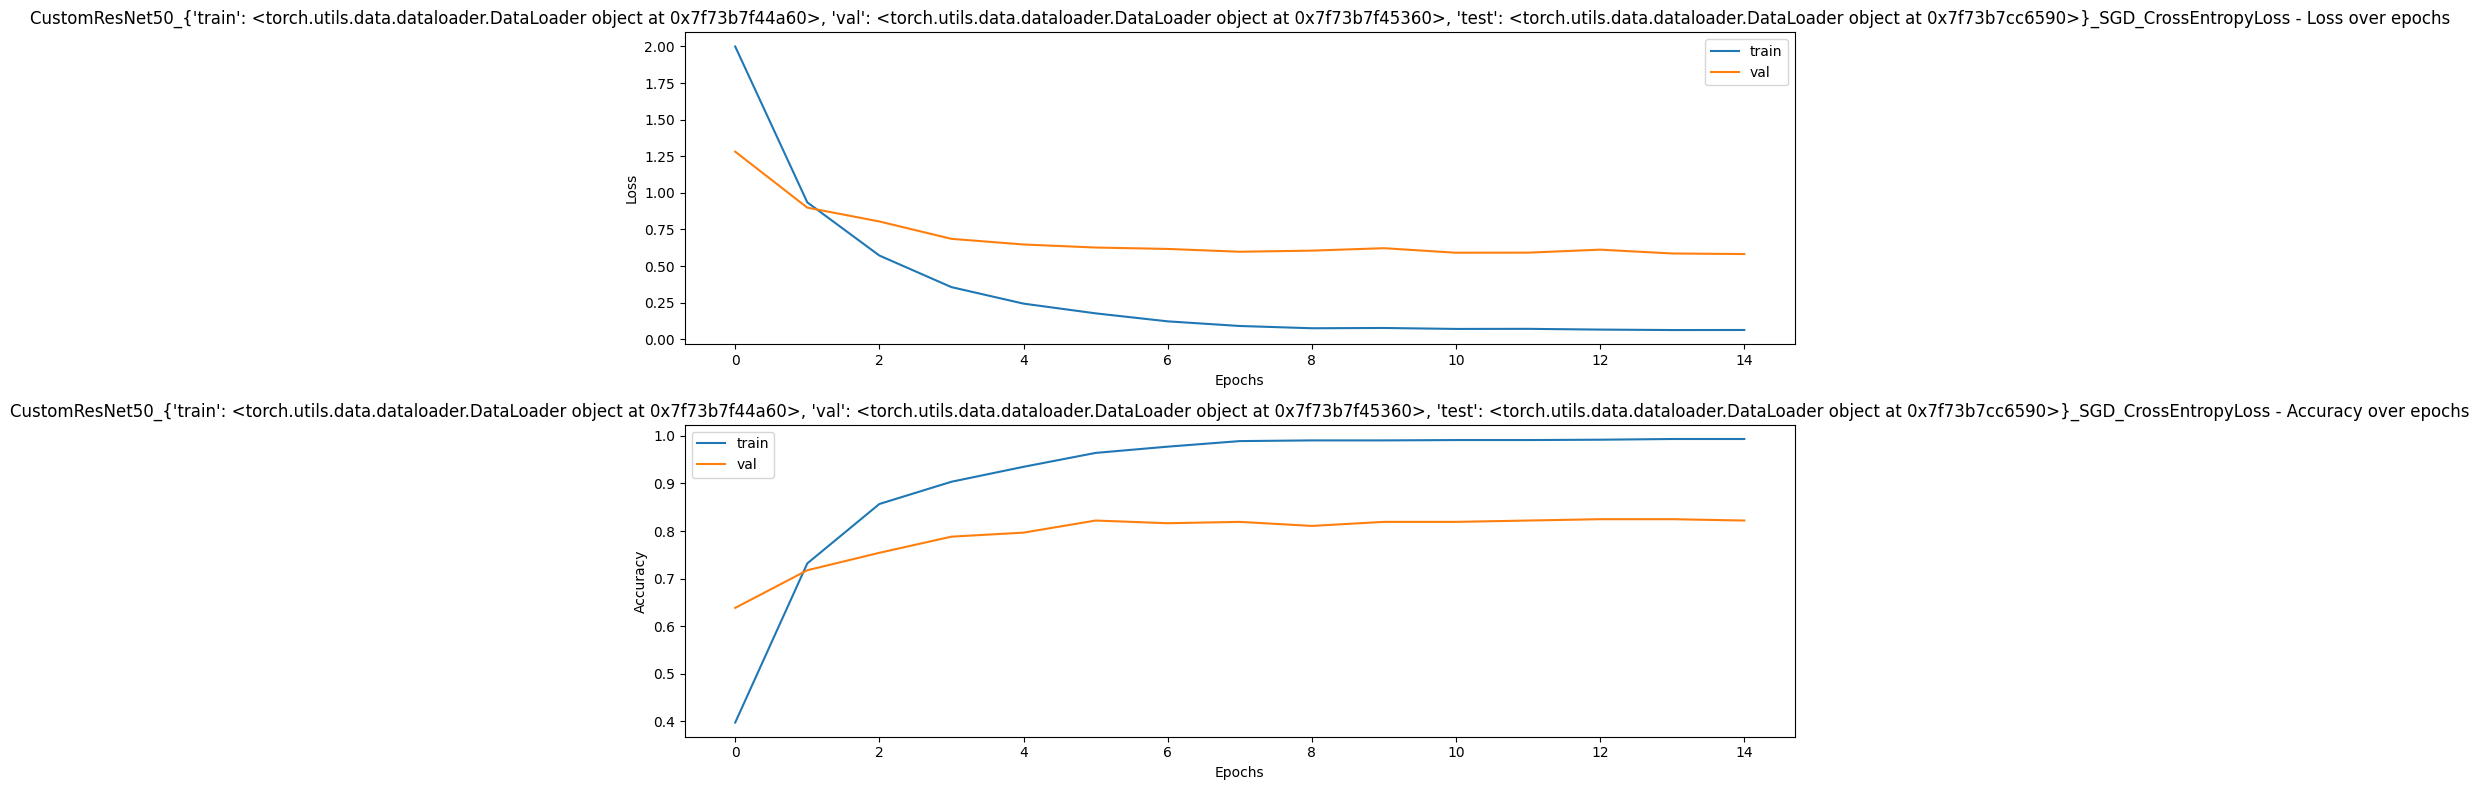


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f44a60>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f45360>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7cc6590>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.5114 Acc: 0.4485
val Loss: 0.7949 Acc: 0.6610

Epoch 1/14
----------
train Loss: 0.5102 Acc: 0.7684
val Loss: 0.5662 Acc: 0.7034

Epoch 2/14
----------
train Loss: 0.3030 Acc: 0.8568
val Loss: 0.4732 Acc: 0.7599

Epoch 3/14
----------
train Loss: 0.1826 Acc: 0.9021
val Loss: 0.4073 Acc: 0.7853

Epoch 4/14
----------
train Loss: 0.1031 Acc: 0.9438
val Loss: 0.3767 Acc: 0.7994

Epoch 5/14
----------
train Loss: 0.0655 Acc: 0.9752
val Loss: 0.3910 Acc: 0.8051

Epoch 6/14
----------
train Loss: 0.0454 Acc: 0.9869
val Loss: 0.4186 Acc: 0.7881

Epoch 7/14
----------
train Loss: 0.0360 Acc: 0.9876
val Loss: 0.3739 Acc: 0.8079

Epoch 8/14
----------
train Loss: 0.0286 Acc: 0.9942
val Loss: 

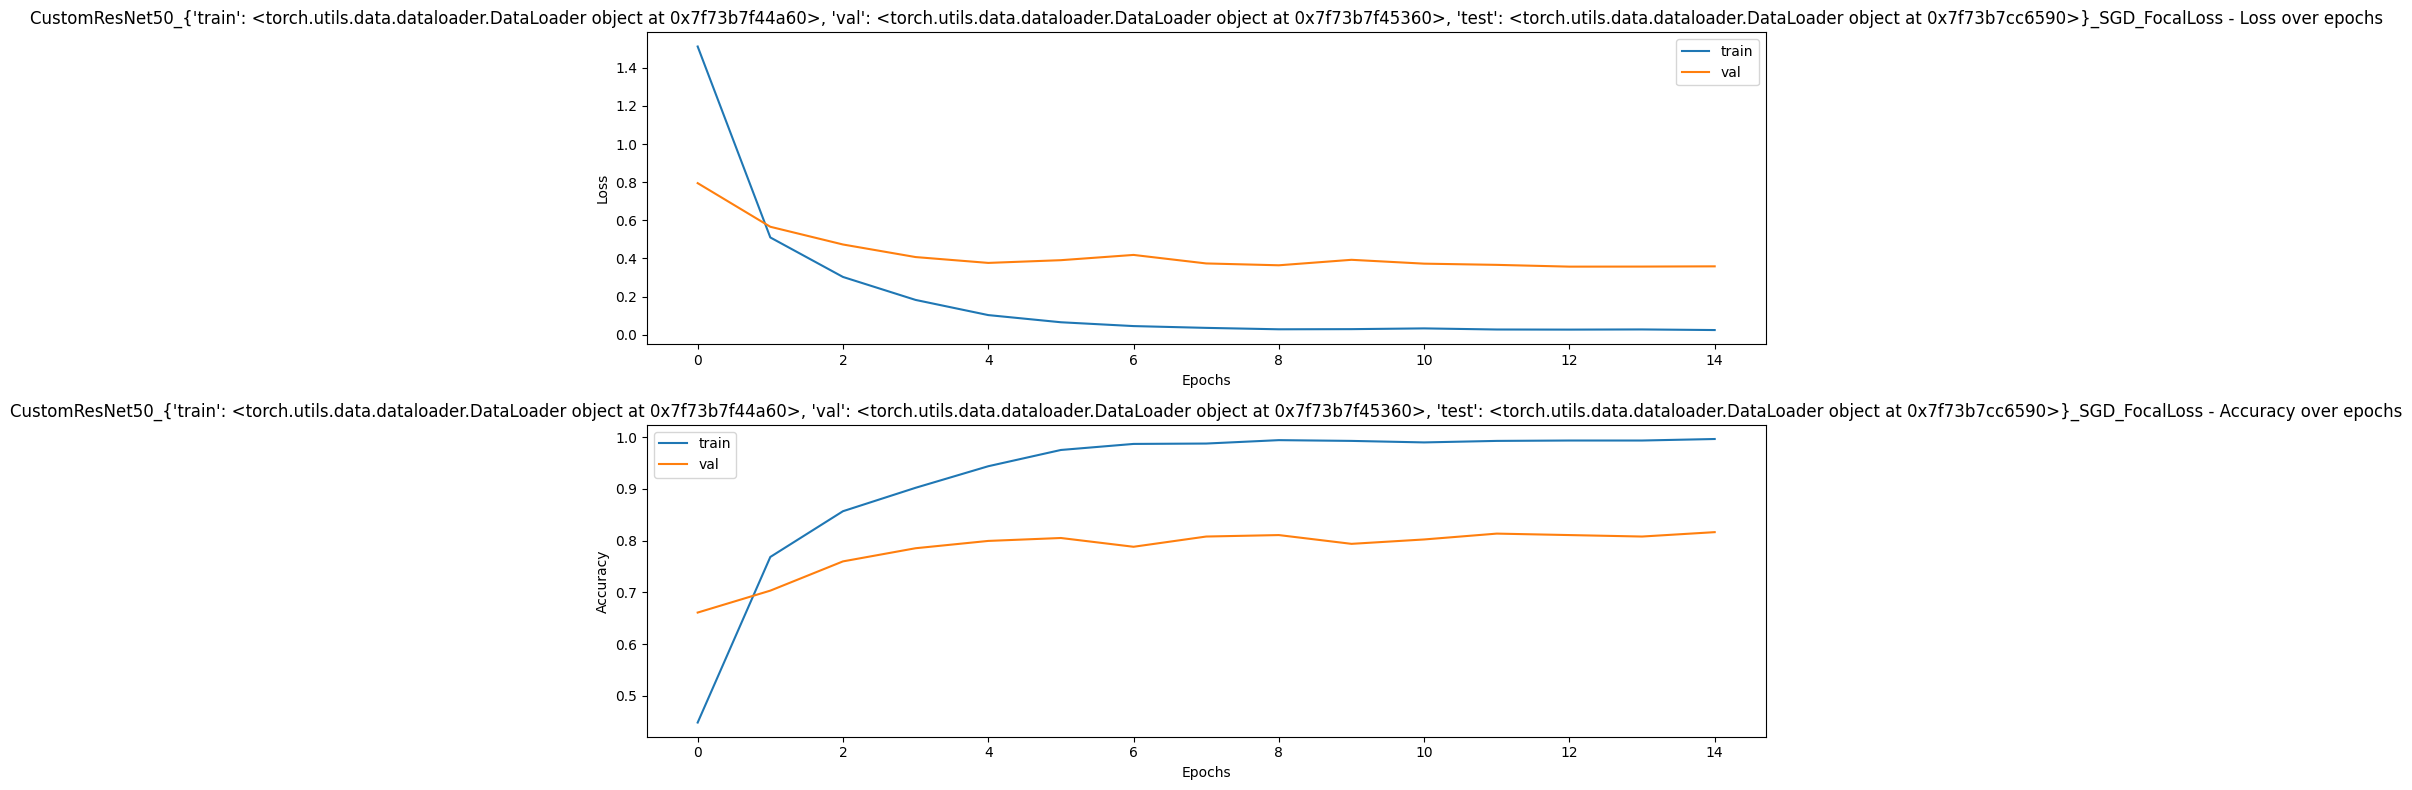


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f44a60>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f45360>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7cc6590>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.6673 Acc: 0.4843
val Loss: 1.6508 Acc: 0.4605

Epoch 1/14
----------
train Loss: 1.3218 Acc: 0.5610
val Loss: 2.4543 Acc: 0.4294

Epoch 2/14
----------
train Loss: 1.1933 Acc: 0.6092
val Loss: 1.5658 Acc: 0.5452

Epoch 3/14
----------
train Loss: 0.8815 Acc: 0.7144
val Loss: 0.9953 Acc: 0.6921

Epoch 4/14
----------
train Loss: 0.8083 Acc: 0.7341
val Loss: 1.4830 Acc: 0.5932

Epoch 5/14
----------
train Loss: 0.7737 Acc: 0.7597
val Loss: 1.3517 Acc: 0.6582

Epoch 6/14
----------
train Loss: 0.6565 Acc: 0.7787
val Loss: 0.8540 Acc: 0.7458

Epoch 7/14
----------
train Loss: 0.3818 Acc: 0.8751
val Loss: 0.6957 Acc: 0.7881

Epoch 8/14
----------
train Loss: 0.3100 Acc: 0.9058
va

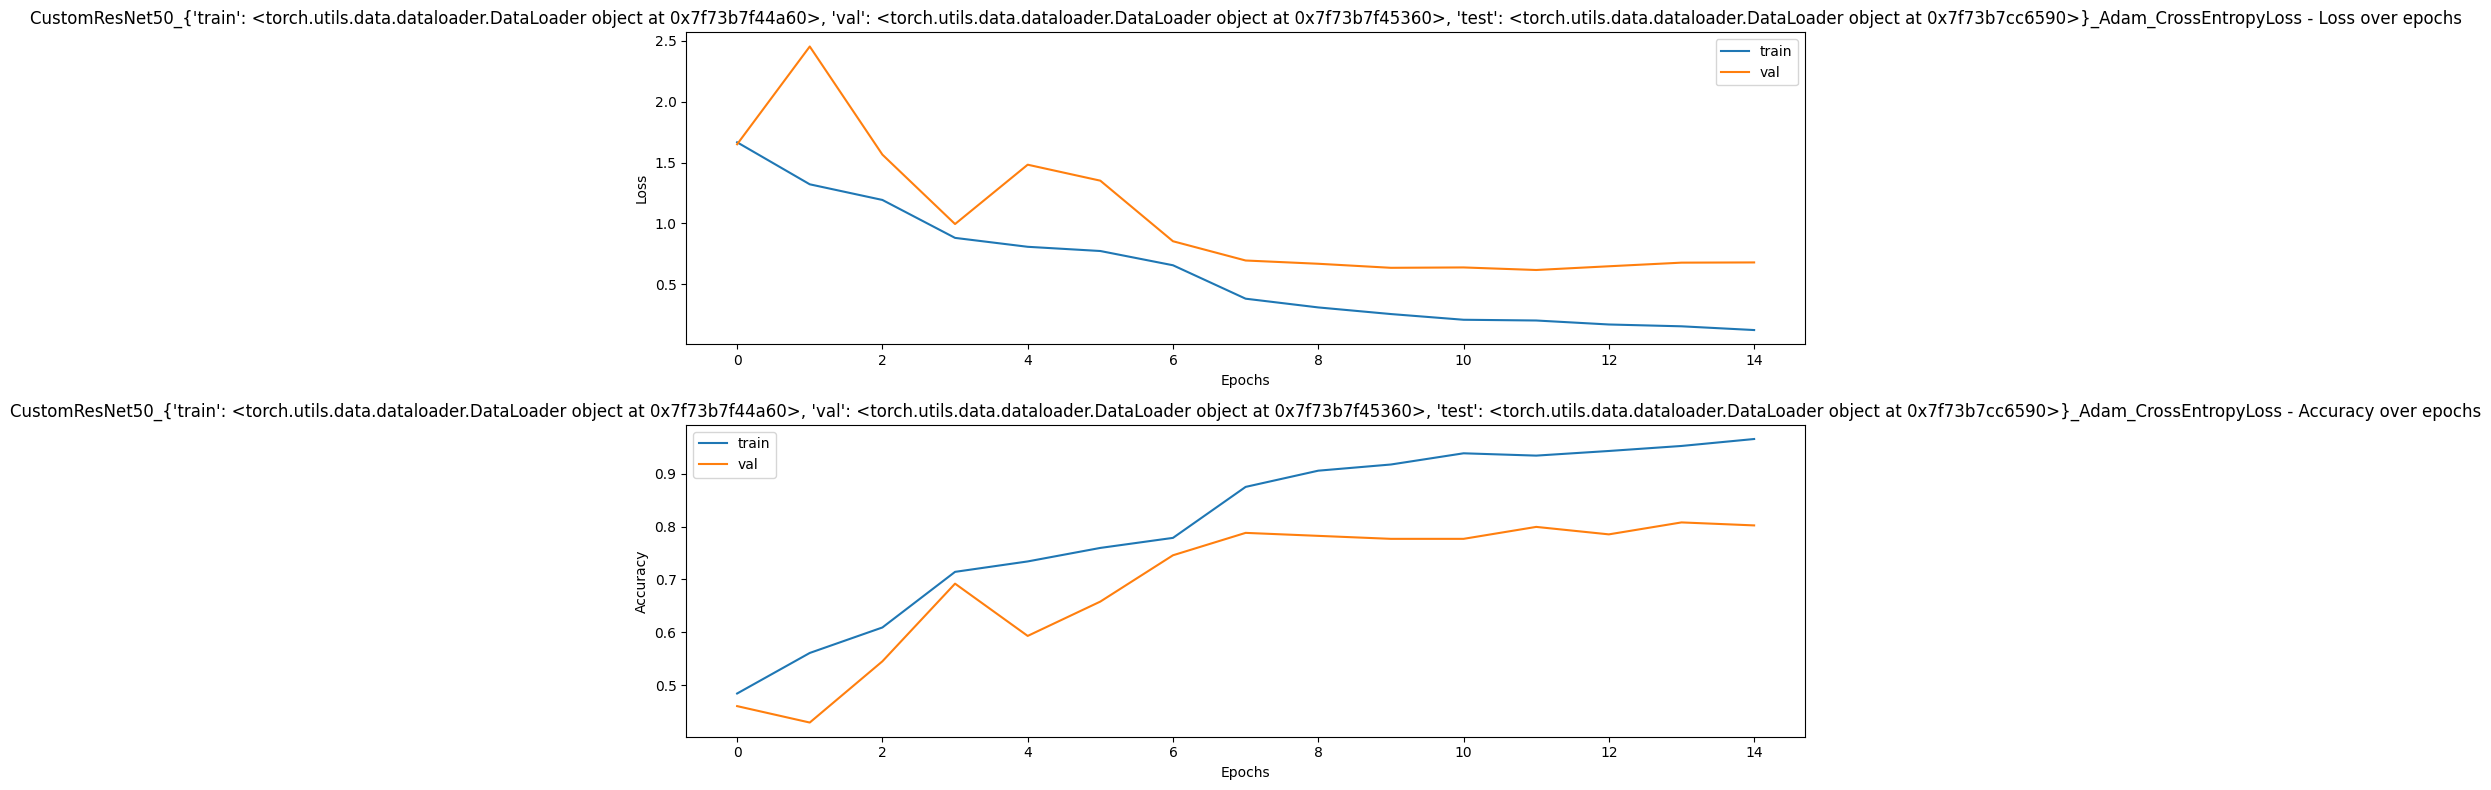


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f44a60>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f45360>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7cc6590>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.4414 Acc: 0.3893
val Loss: 3.1552 Acc: 0.3192

Epoch 1/14
----------
train Loss: 0.9285 Acc: 0.5128
val Loss: 1.1081 Acc: 0.4718

Epoch 2/14
----------
train Loss: 0.8195 Acc: 0.5676
val Loss: 1.6162 Acc: 0.4887

Epoch 3/14
----------
train Loss: 0.6547 Acc: 0.6545
val Loss: 0.8855 Acc: 0.5650

Epoch 4/14
----------
train Loss: 0.5830 Acc: 0.6720
val Loss: 0.7324 Acc: 0.6299

Epoch 5/14
----------
train Loss: 0.5337 Acc: 0.6983
val Loss: 3.7458 Acc: 0.3672

Epoch 6/14
----------
train Loss: 0.4649 Acc: 0.7144
val Loss: 0.7710 Acc: 0.6723

Epoch 7/14
----------
train Loss: 0.2593 Acc: 0.8276
val Loss: 0.6058 Acc: 0.7175

Epoch 8/14
----------
train Loss: 0.1948 Acc: 0.8598
val Loss:

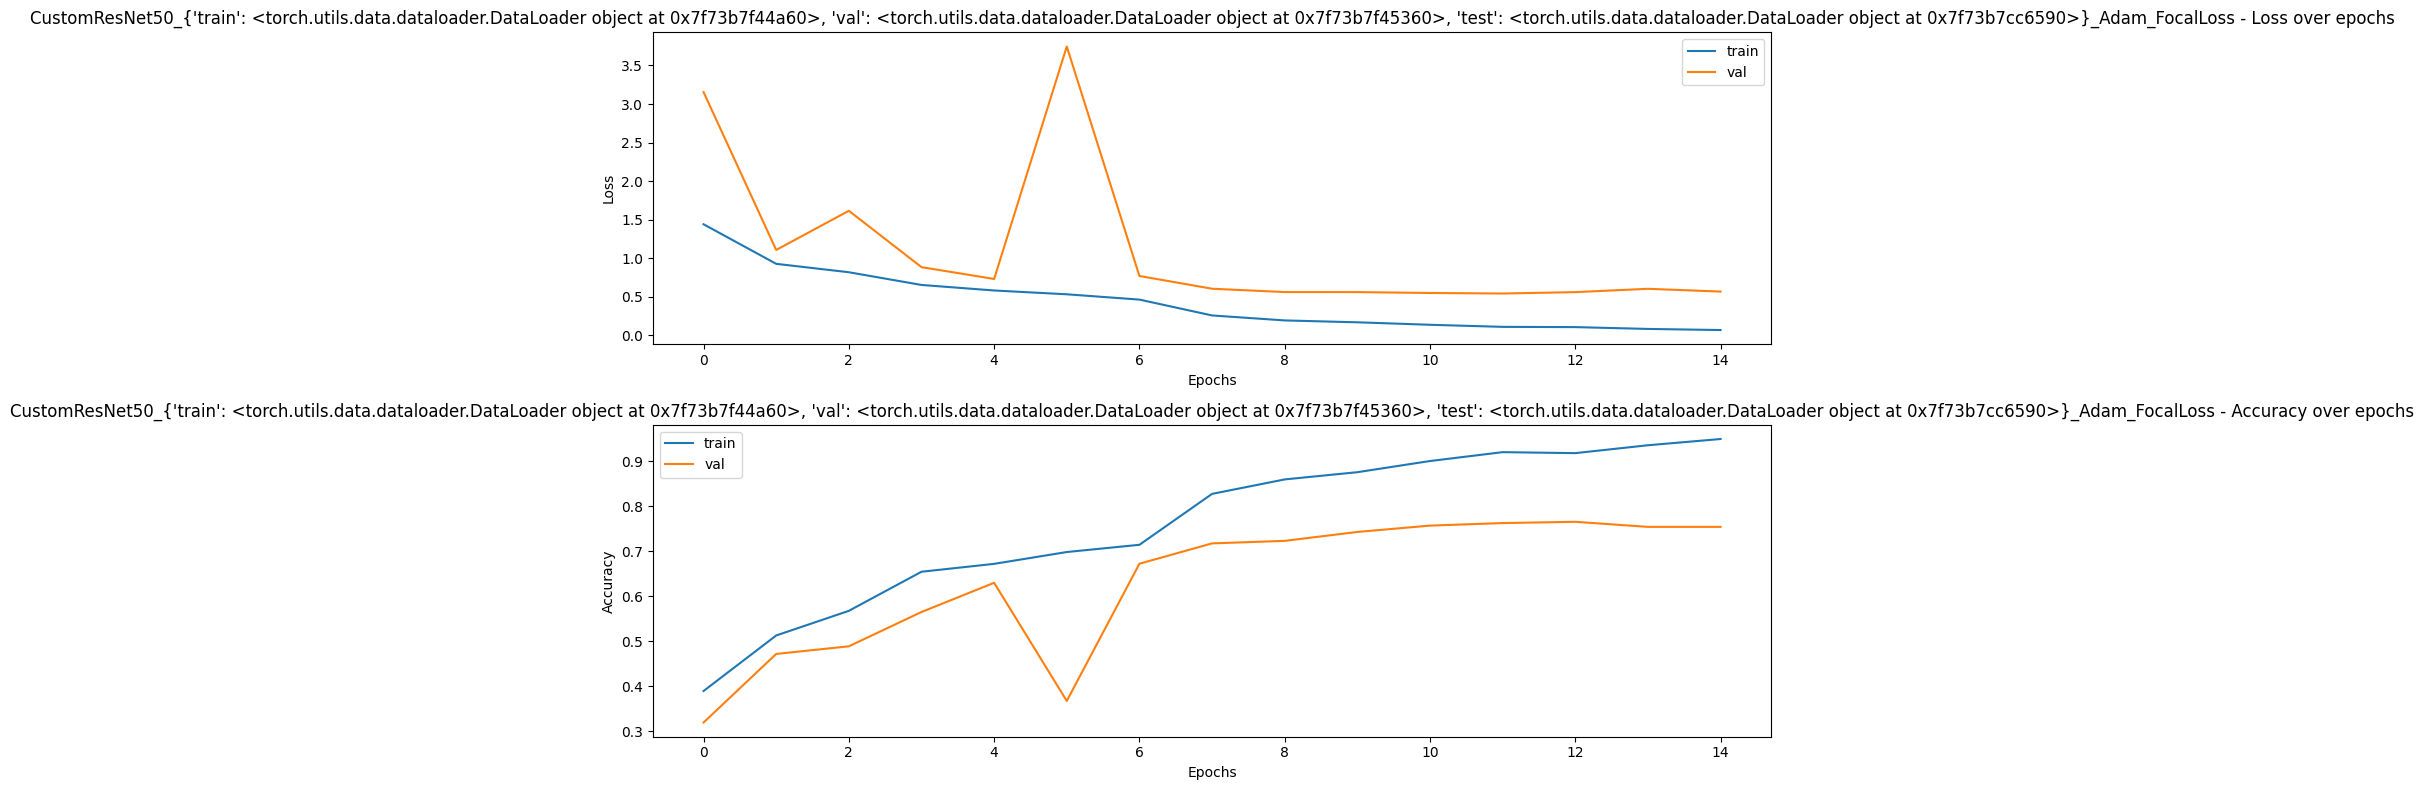


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7fb0130>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a6f80>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a55d0>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.0158 Acc: 0.3806
val Loss: 1.4032 Acc: 0.5734

Epoch 1/14
----------
train Loss: 1.0820 Acc: 0.6852
val Loss: 0.8958 Acc: 0.7119

Epoch 2/14
----------
train Loss: 0.6824 Acc: 0.8130
val Loss: 0.7406 Acc: 0.7627

Epoch 3/14
----------
train Loss: 0.4895 Acc: 0.8524
val Loss: 0.6186 Acc: 0.7938

Epoch 4/14
----------
train Loss: 0.3503 Acc: 0.9014
val Loss: 0.7726 Acc: 0.7571

Epoch 5/14
----------
train Loss: 0.2665 Acc: 0.9233
val Loss: 0.6320 Acc: 0.8107

Epoch 6/14
----------
train Loss: 0.1848 Acc: 0.9562
val Loss: 0.6354 Acc: 0.8136

Epoch 7/14
----------
train Loss: 0.1569 Acc: 0.9693
val Loss: 0.5659 Acc: 0.8249

Epoch 8/14
----------
train Loss: 0.1310 Acc: 0.9737
val

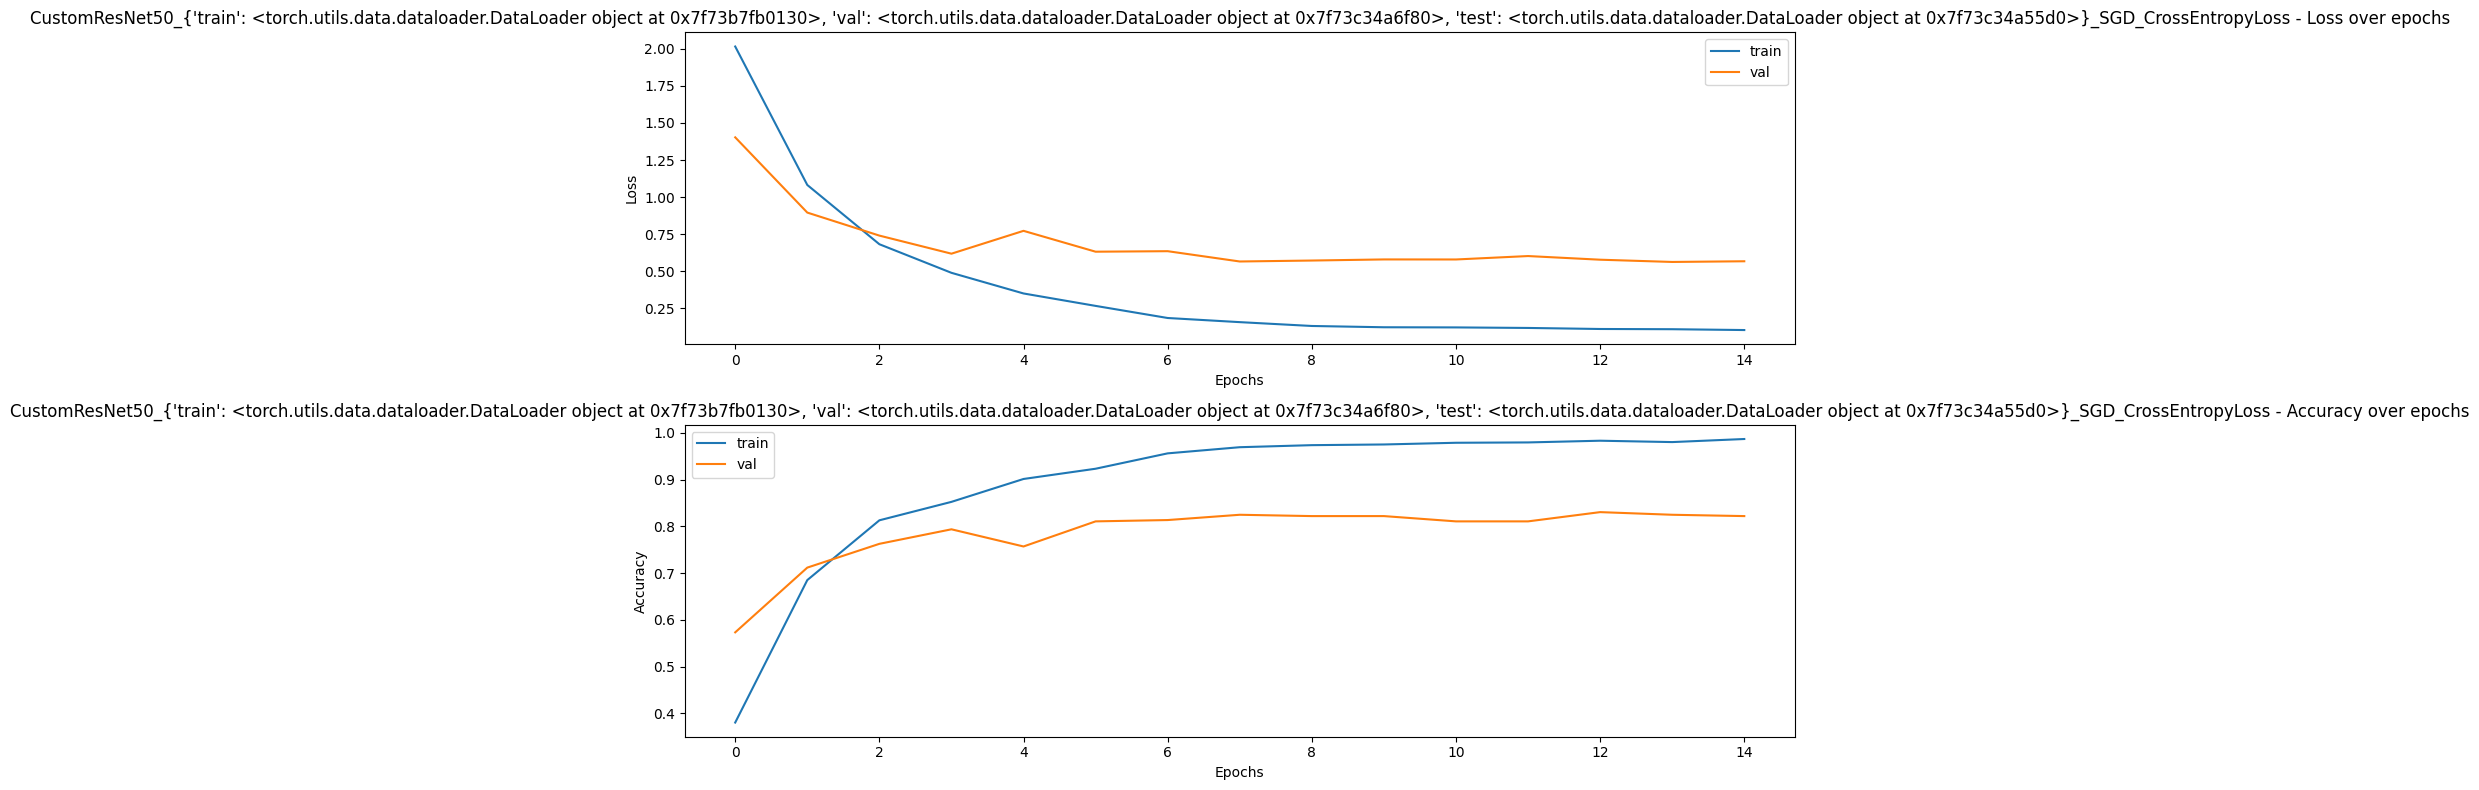


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7fb0130>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a6f80>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a55d0>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.5891 Acc: 0.3981
val Loss: 0.8654 Acc: 0.6130

Epoch 1/14
----------
train Loss: 0.5920 Acc: 0.7327
val Loss: 0.5869 Acc: 0.7345

Epoch 2/14
----------
train Loss: 0.3664 Acc: 0.8064
val Loss: 0.5273 Acc: 0.7316

Epoch 3/14
----------
train Loss: 0.2237 Acc: 0.8773
val Loss: 0.4870 Acc: 0.7571

Epoch 4/14
----------
train Loss: 0.1673 Acc: 0.9138
val Loss: 0.4329 Acc: 0.7994

Epoch 5/14
----------
train Loss: 0.1031 Acc: 0.9481
val Loss: 0.4515 Acc: 0.7768

Epoch 6/14
----------
train Loss: 0.0810 Acc: 0.9540
val Loss: 0.4200 Acc: 0.7853

Epoch 7/14
----------
train Loss: 0.0614 Acc: 0.9620
val Loss: 0.4249 Acc: 0.7938

Epoch 8/14
----------
train Loss: 0.0466 Acc: 0.9795
val Loss: 

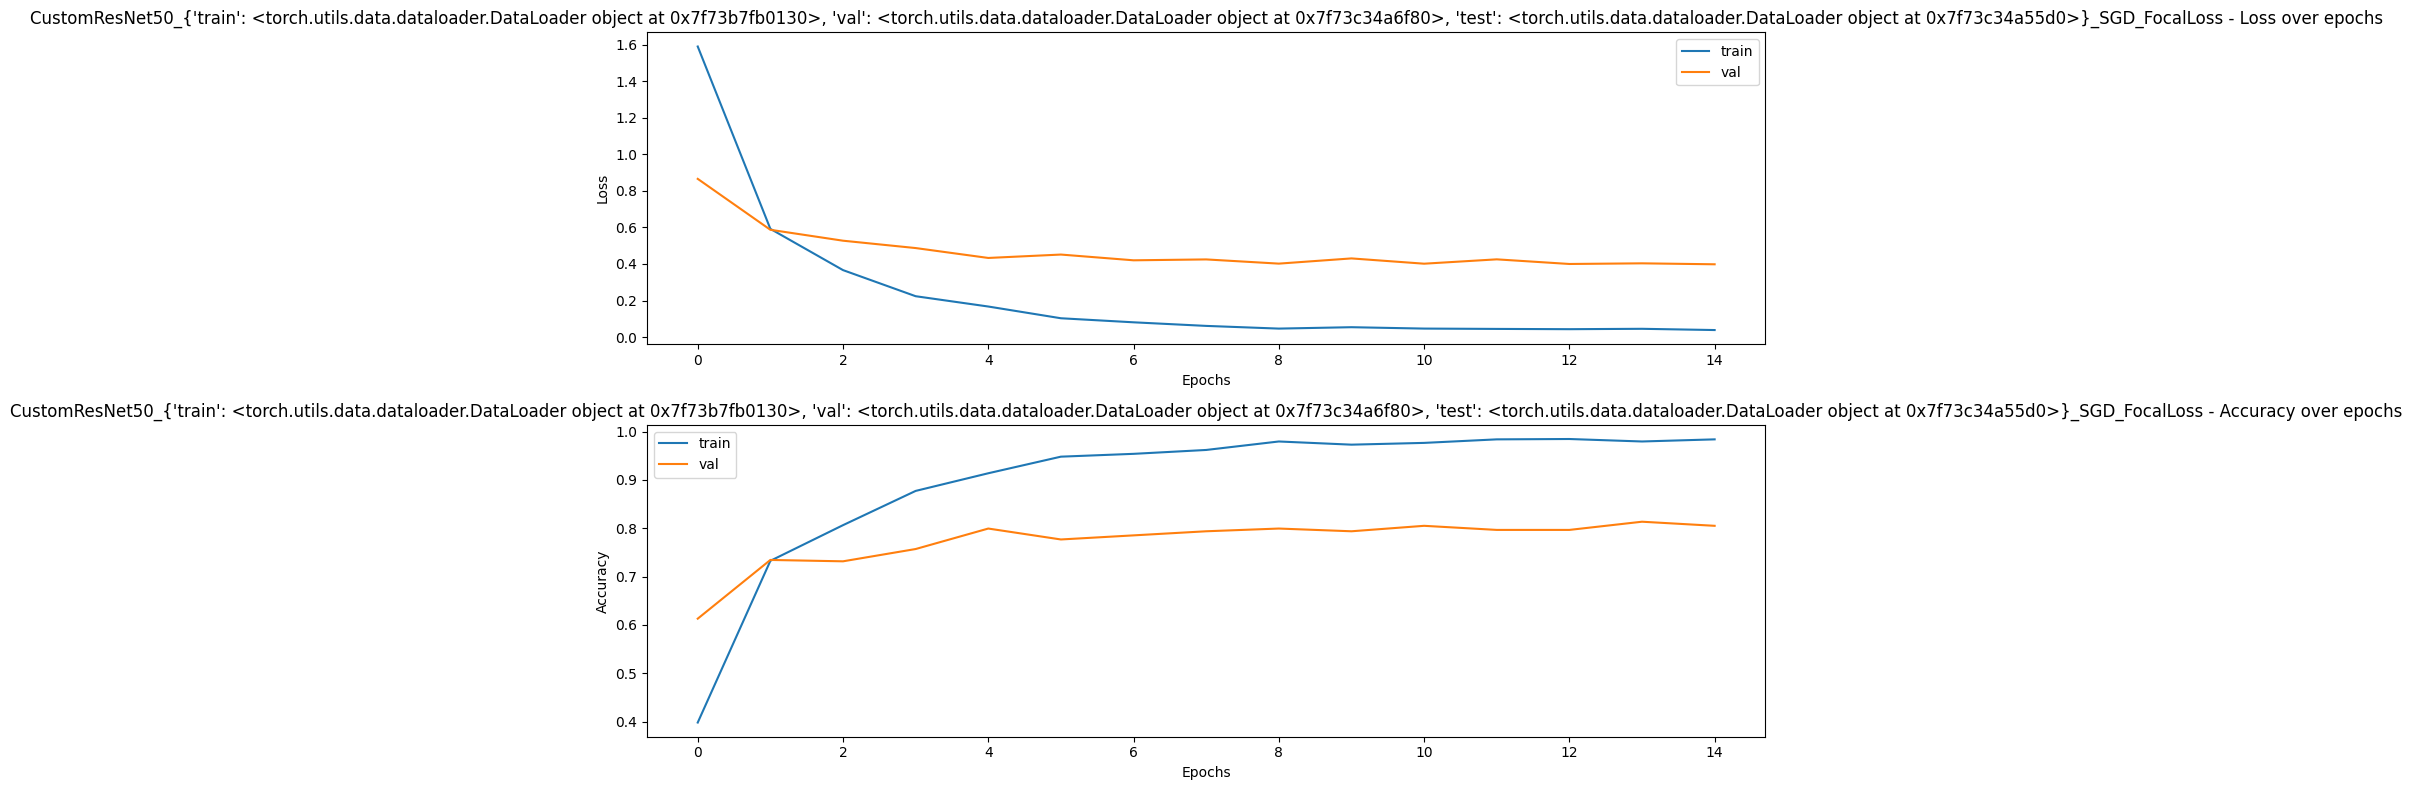


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7fb0130>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a6f80>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a55d0>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9246 Acc: 0.3864
val Loss: 2.7516 Acc: 0.3418

Epoch 1/14
----------
train Loss: 1.4201 Acc: 0.5069
val Loss: 2.0126 Acc: 0.3983

Epoch 2/14
----------
train Loss: 1.1567 Acc: 0.5982
val Loss: 1.6819 Acc: 0.5113

Epoch 3/14
----------
train Loss: 1.1058 Acc: 0.6224
val Loss: 1.4048 Acc: 0.5621

Epoch 4/14
----------
train Loss: 0.9149 Acc: 0.6859
val Loss: 1.4001 Acc: 0.5565

Epoch 5/14
----------
train Loss: 0.8302 Acc: 0.7224
val Loss: 1.7765 Acc: 0.5198

Epoch 6/14
----------
train Loss: 0.7959 Acc: 0.7348
val Loss: 2.4846 Acc: 0.4972

Epoch 7/14
----------
train Loss: 0.5009 Acc: 0.8313
val Loss: 0.8900 Acc: 0.7175

Epoch 8/14
----------
train Loss: 0.3920 Acc: 0.8787
va

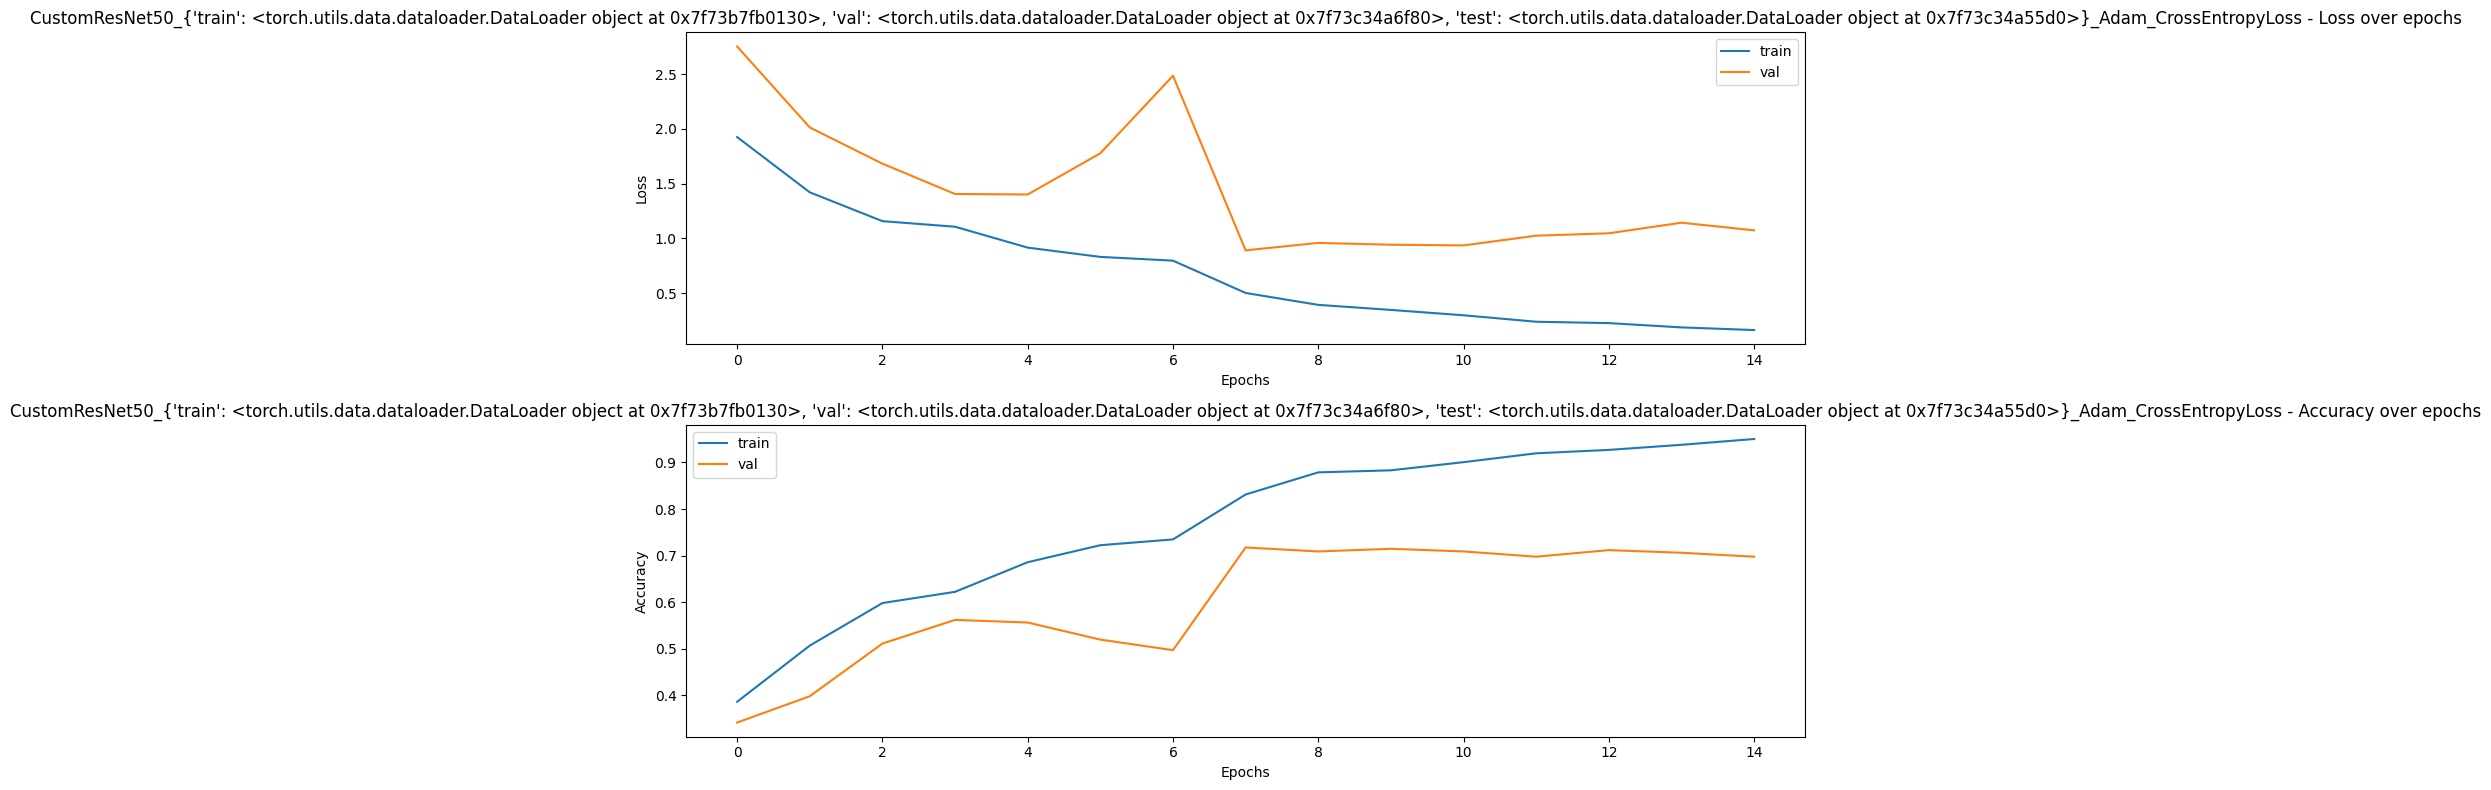


Training with CustomResNet50, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7fb0130>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a6f80>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a55d0>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.5807 Acc: 0.3506
val Loss: 2.8433 Acc: 0.2712

Epoch 1/14
----------
train Loss: 0.9802 Acc: 0.5223
val Loss: 1.9516 Acc: 0.4068

Epoch 2/14
----------
train Loss: 0.7644 Acc: 0.6129
val Loss: 1.1623 Acc: 0.4718

Epoch 3/14
----------
train Loss: 0.6015 Acc: 0.6581
val Loss: 0.8659 Acc: 0.5989

Epoch 4/14
----------
train Loss: 0.5190 Acc: 0.7180
val Loss: 0.9457 Acc: 0.5734

Epoch 5/14
----------
train Loss: 0.5071 Acc: 0.7078
val Loss: 1.5911 Acc: 0.4407

Epoch 6/14
----------
train Loss: 0.3592 Acc: 0.7736
val Loss: 1.2017 Acc: 0.5621

Epoch 7/14
----------
train Loss: 0.2363 Acc: 0.8532
val Loss: 0.5198 Acc: 0.7260

Epoch 8/14
----------
train Loss: 0.1445 Acc: 0.9028
val Loss:

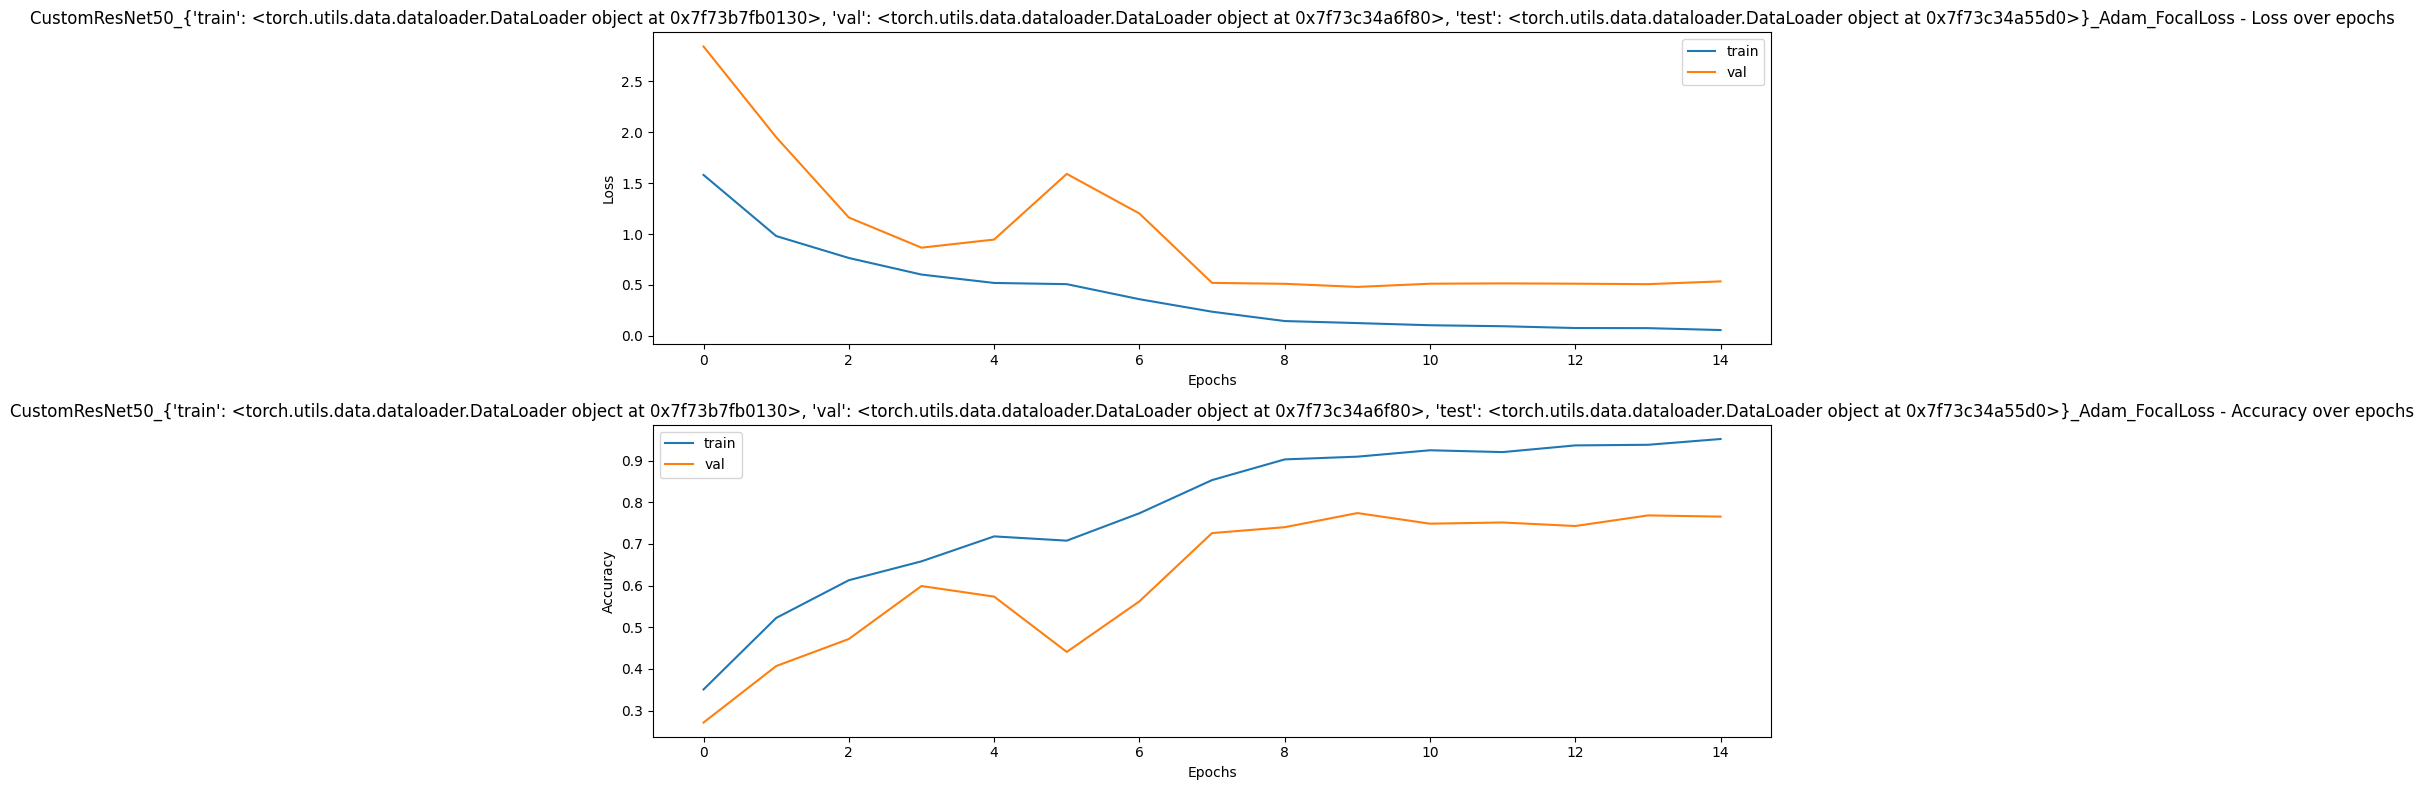


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f44a60>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f45360>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7cc6590>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.5248 Acc: 0.2082
val Loss: 2.1573 Acc: 0.3249

Epoch 1/14
----------
train Loss: 1.7558 Acc: 0.4828
val Loss: 1.4653 Acc: 0.5508

Epoch 2/14
----------
train Loss: 1.1316 Acc: 0.6691
val Loss: 1.0136 Acc: 0.6780

Epoch 3/14
----------
train Loss: 0.7536 Acc: 0.7925
val Loss: 0.8096 Acc: 0.7514

Epoch 4/14
----------
train Loss: 0.5497 Acc: 0.8422
val Loss: 0.7124 Acc: 0.7768

Epoch 5/14
----------
train Loss: 0.3890 Acc: 0.8926
val Loss: 0.6582 Acc: 0.7853

Epoch 6/14
----------
train Loss: 0.2941 Acc: 0.9116
val Loss: 0.6496 Acc: 0.8107

Epoch 7/14
----------
train Loss: 0.2233 Acc: 0.9445
val Loss: 0.6427 Acc: 0.8107

Epoch 8/14
----------
train Loss: 0.2150 Acc: 0.9525
va

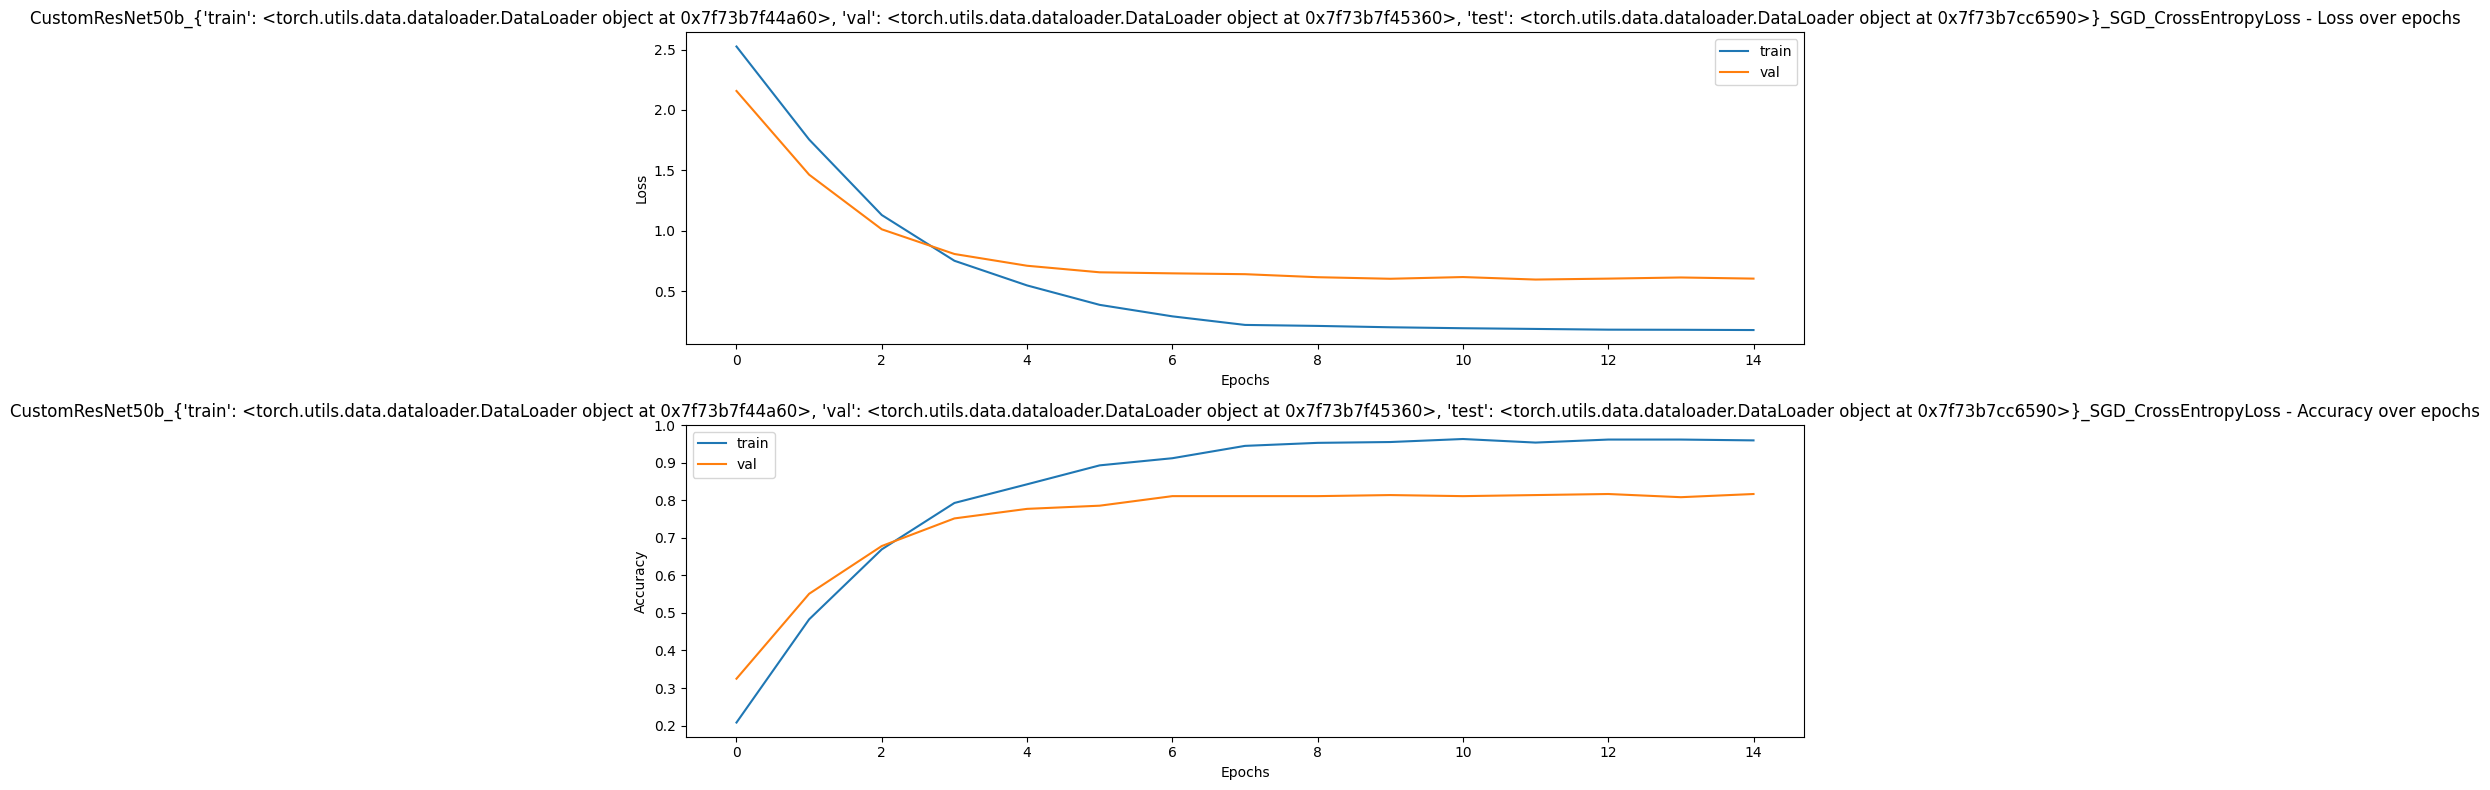


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f44a60>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f45360>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7cc6590>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 2.1021 Acc: 0.2213
val Loss: 1.6798 Acc: 0.2966

Epoch 1/14
----------
train Loss: 1.1914 Acc: 0.5391
val Loss: 0.8876 Acc: 0.6469

Epoch 2/14
----------
train Loss: 0.6181 Acc: 0.7253
val Loss: 0.6142 Acc: 0.7429

Epoch 3/14
----------
train Loss: 0.3838 Acc: 0.8130
val Loss: 0.4821 Acc: 0.7627

Epoch 4/14
----------
train Loss: 0.2400 Acc: 0.8663
val Loss: 0.4533 Acc: 0.7627

Epoch 5/14
----------
train Loss: 0.1758 Acc: 0.9094
val Loss: 0.4426 Acc: 0.7740

Epoch 6/14
----------
train Loss: 0.1328 Acc: 0.9306
val Loss: 0.4192 Acc: 0.7938

Epoch 7/14
----------
train Loss: 0.1006 Acc: 0.9481
val Loss: 0.3857 Acc: 0.8107

Epoch 8/14
----------
train Loss: 0.0883 Acc: 0.9598
val Loss:

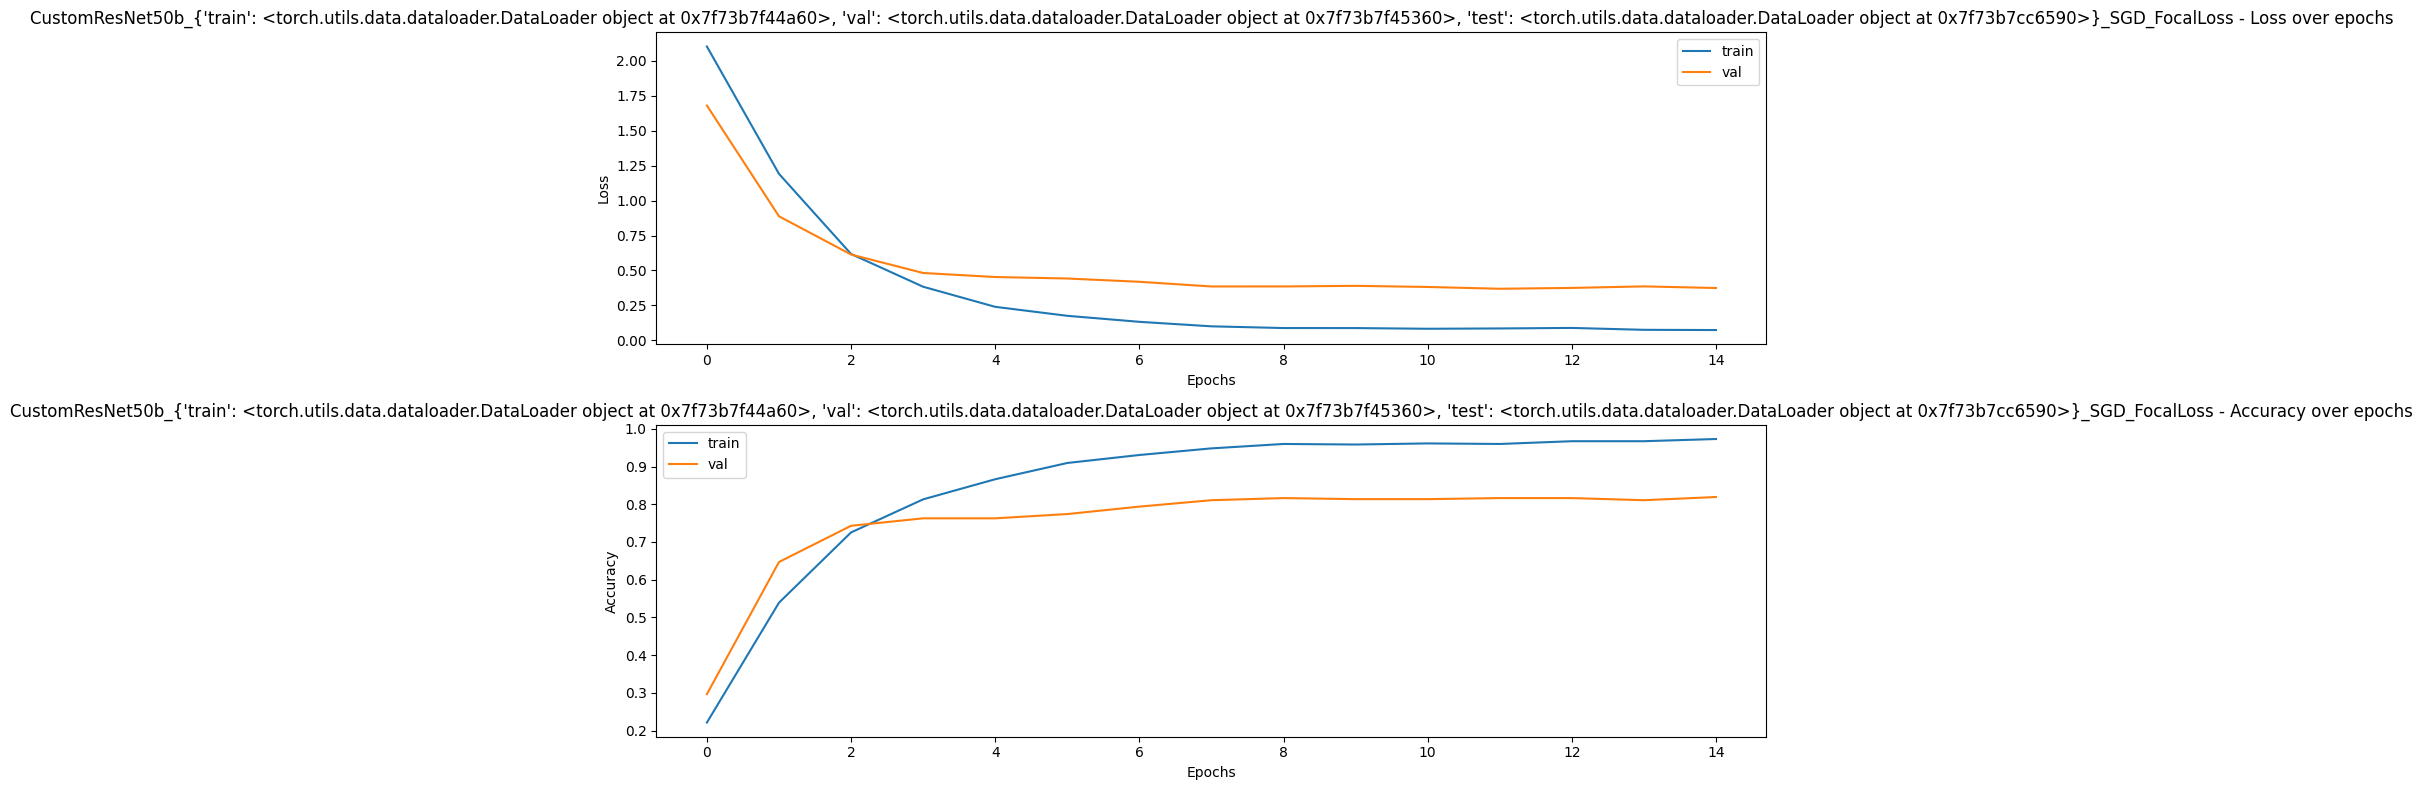


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f44a60>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f45360>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7cc6590>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9792 Acc: 0.3477
val Loss: 2.4637 Acc: 0.2627

Epoch 1/14
----------
train Loss: 1.4993 Acc: 0.4697
val Loss: 1.5451 Acc: 0.4294

Epoch 2/14
----------
train Loss: 1.3613 Acc: 0.5194
val Loss: 1.7002 Acc: 0.4124

Epoch 3/14
----------
train Loss: 1.2415 Acc: 0.5435
val Loss: 2.1785 Acc: 0.3418

Epoch 4/14
----------
train Loss: 1.1416 Acc: 0.5785
val Loss: 1.9803 Acc: 0.4209

Epoch 5/14
----------
train Loss: 1.0581 Acc: 0.6253
val Loss: 1.6096 Acc: 0.4661

Epoch 6/14
----------
train Loss: 0.9703 Acc: 0.6618
val Loss: 2.0833 Acc: 0.4605

Epoch 7/14
----------
train Loss: 0.8467 Acc: 0.7034
val Loss: 0.9667 Acc: 0.6864

Epoch 8/14
----------
train Loss: 0.6745 Acc: 0.7582
v

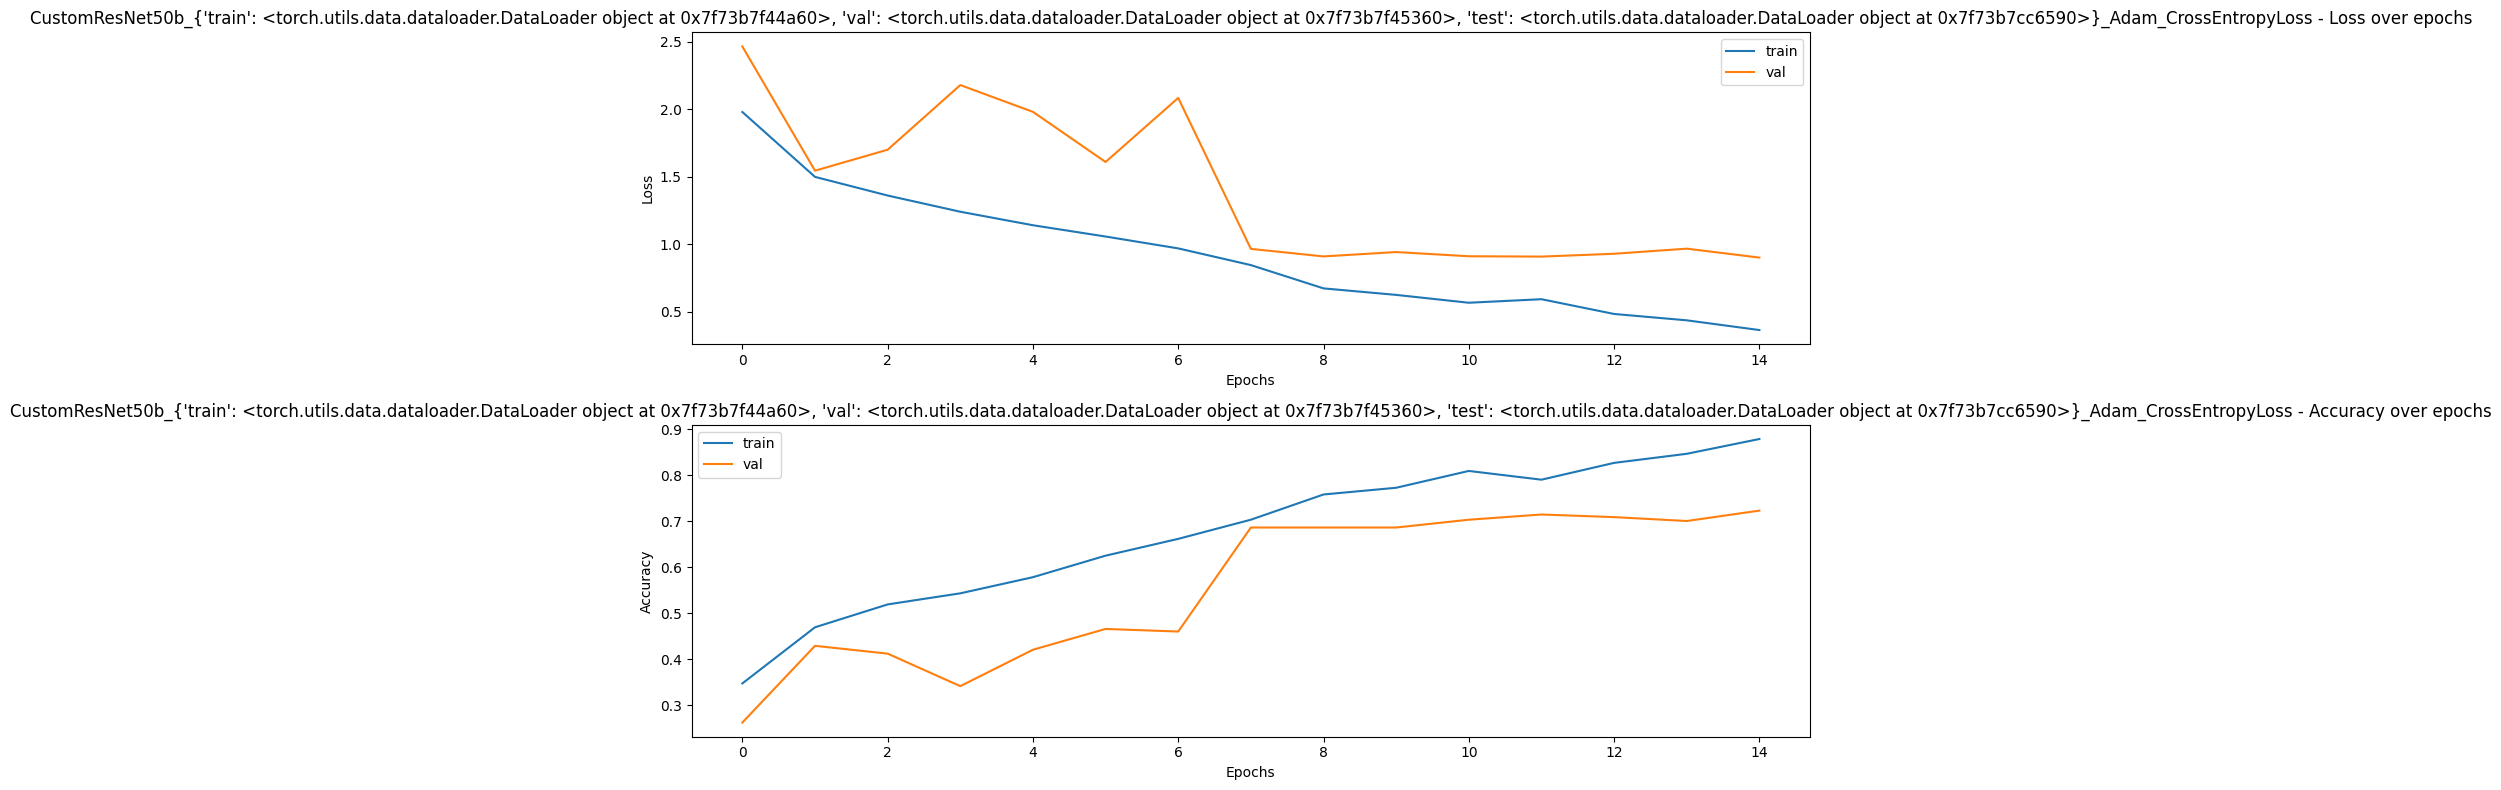


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f44a60>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f45360>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7cc6590>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.7288 Acc: 0.2652
val Loss: 6.6772 Acc: 0.1977

Epoch 1/14
----------
train Loss: 1.2015 Acc: 0.4178
val Loss: 1.2647 Acc: 0.4322

Epoch 2/14
----------
train Loss: 0.8567 Acc: 0.5464
val Loss: 1.2392 Acc: 0.4746

Epoch 3/14
----------
train Loss: 0.8114 Acc: 0.5639
val Loss: 1.4477 Acc: 0.4011

Epoch 4/14
----------
train Loss: 0.7158 Acc: 0.5902
val Loss: 1.1319 Acc: 0.5000

Epoch 5/14
----------
train Loss: 0.6665 Acc: 0.6092
val Loss: 23.8013 Acc: 0.1864

Epoch 6/14
----------
train Loss: 0.6146 Acc: 0.6063
val Loss: 1.2026 Acc: 0.5056

Epoch 7/14
----------
train Loss: 0.4878 Acc: 0.7144
val Loss: 0.6790 Acc: 0.6384

Epoch 8/14
----------
train Loss: 0.4247 Acc: 0.7392
val Los

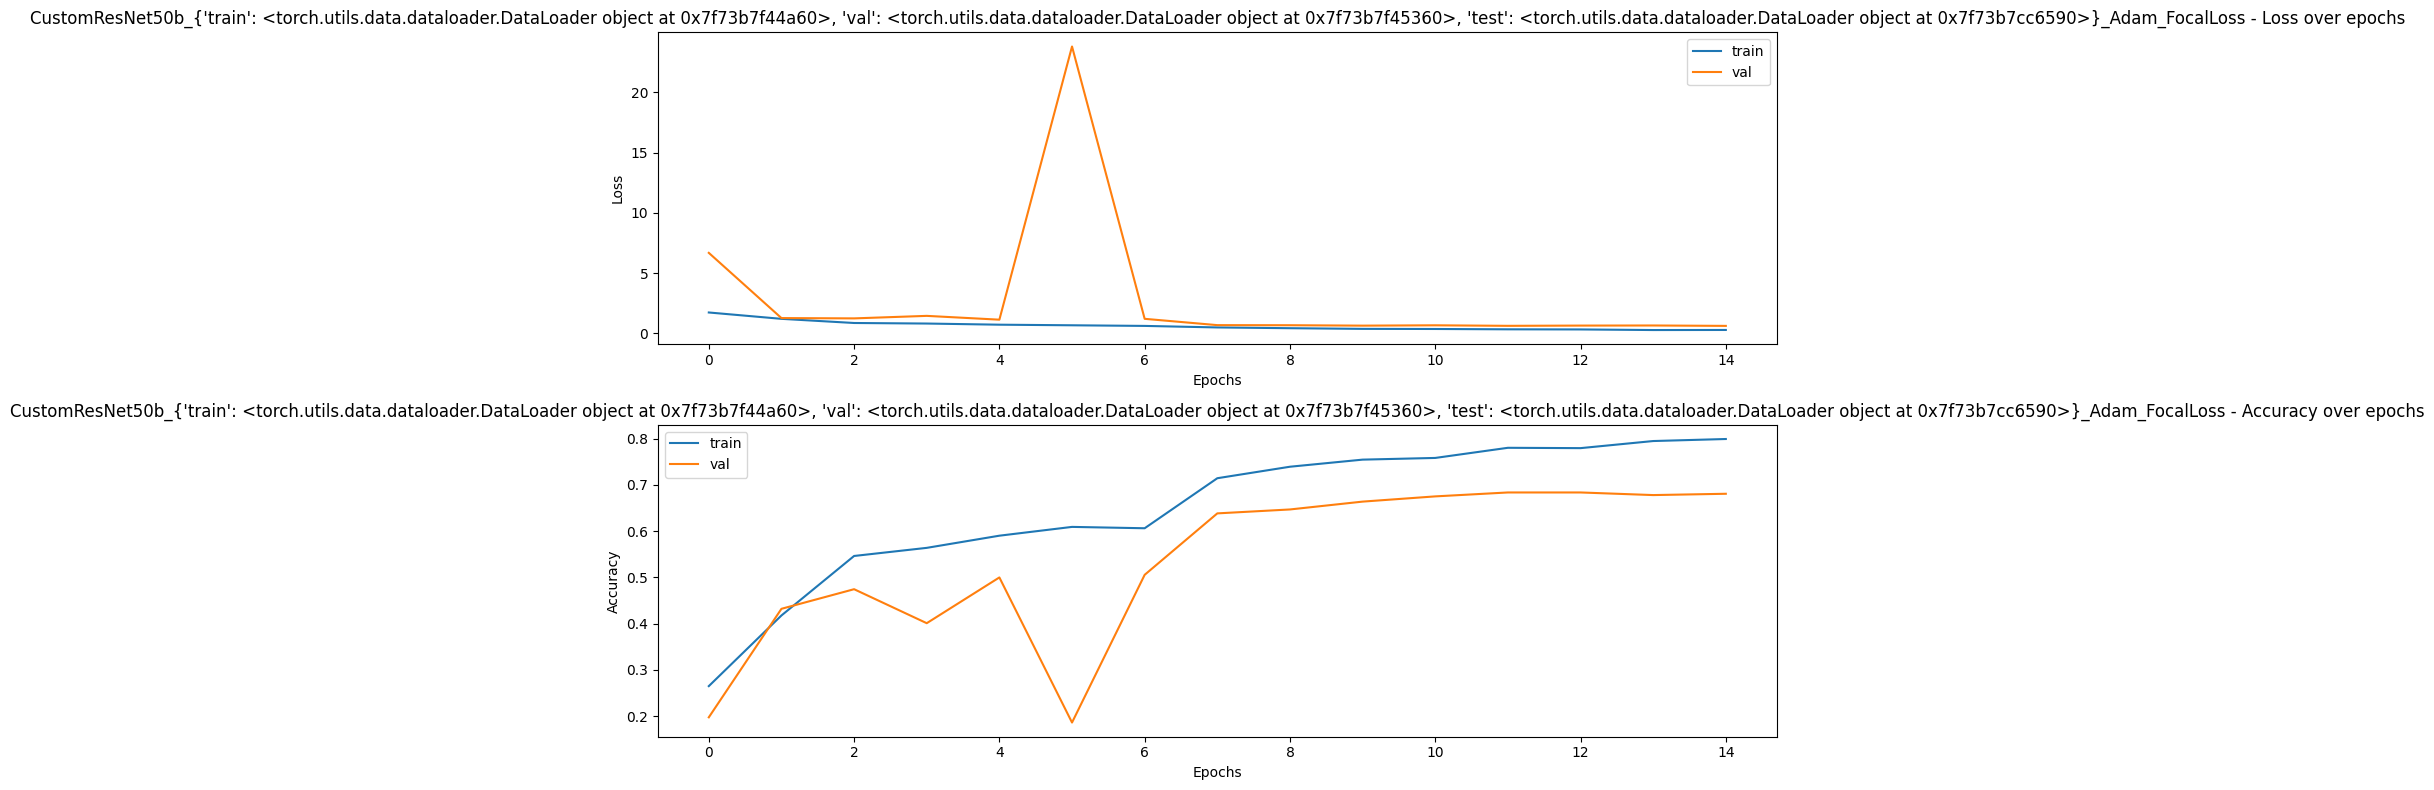


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7fb0130>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a6f80>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a55d0>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.5475 Acc: 0.2111
val Loss: 2.1537 Acc: 0.2994

Epoch 1/14
----------
train Loss: 1.8087 Acc: 0.4507
val Loss: 1.4730 Acc: 0.5791

Epoch 2/14
----------
train Loss: 1.2371 Acc: 0.6362
val Loss: 1.1327 Acc: 0.6638

Epoch 3/14
----------
train Loss: 0.9001 Acc: 0.7327
val Loss: 0.8889 Acc: 0.7316

Epoch 4/14
----------
train Loss: 0.6928 Acc: 0.7962
val Loss: 0.7549 Acc: 0.7655

Epoch 5/14
----------
train Loss: 0.5060 Acc: 0.8422
val Loss: 0.8064 Acc: 0.7429

Epoch 6/14
----------
train Loss: 0.3980 Acc: 0.8875
val Loss: 0.6374 Acc: 0.7966

Epoch 7/14
----------
train Loss: 0.3145 Acc: 0.9131
val Loss: 0.5980 Acc: 0.8107

Epoch 8/14
----------
train Loss: 0.3114 Acc: 0.9123
va

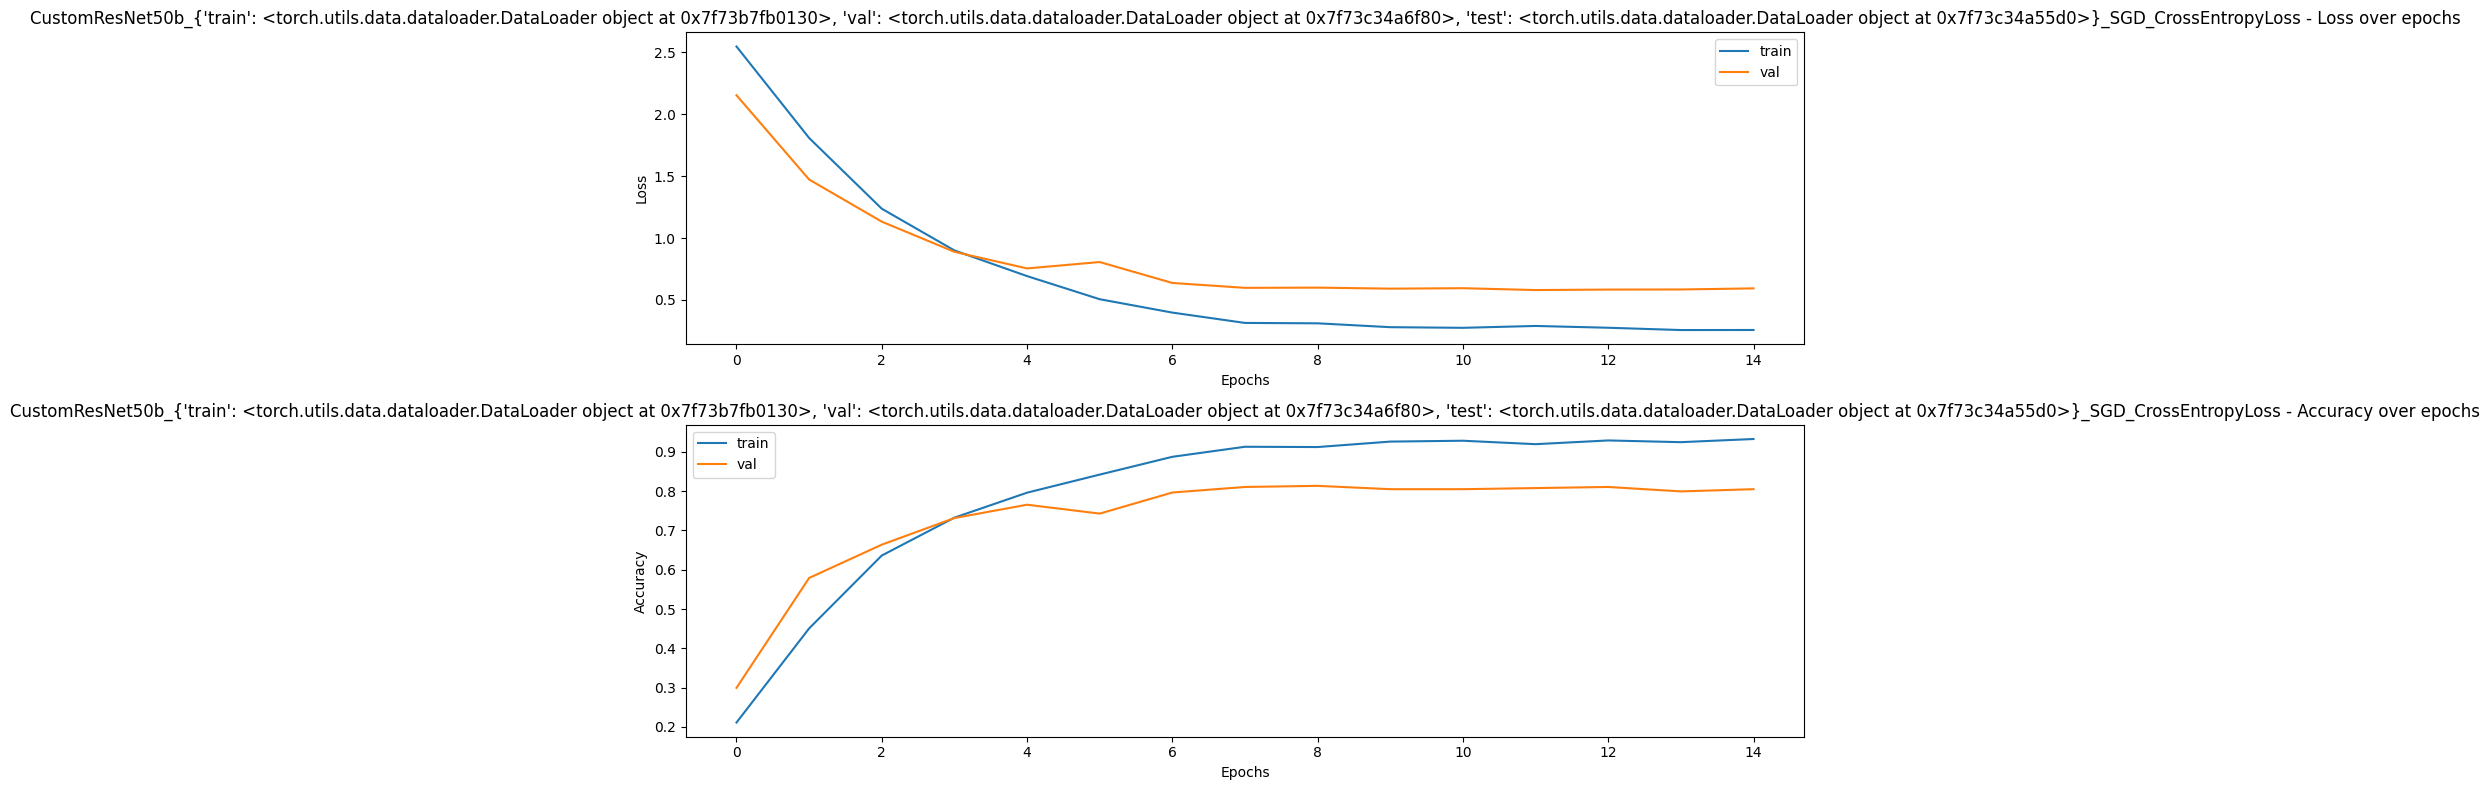


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7fb0130>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a6f80>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a55d0>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 2.1395 Acc: 0.1980
val Loss: 1.6569 Acc: 0.3729

Epoch 1/14
----------
train Loss: 1.2746 Acc: 0.5223
val Loss: 1.1162 Acc: 0.5113

Epoch 2/14
----------
train Loss: 0.7107 Acc: 0.6859
val Loss: 0.6794 Acc: 0.7006

Epoch 3/14
----------
train Loss: 0.4721 Acc: 0.7684
val Loss: 0.5487 Acc: 0.7260

Epoch 4/14
----------
train Loss: 0.3416 Acc: 0.8093
val Loss: 0.5074 Acc: 0.7401

Epoch 5/14
----------
train Loss: 0.2421 Acc: 0.8685
val Loss: 0.5108 Acc: 0.7627

Epoch 6/14
----------
train Loss: 0.1920 Acc: 0.8766
val Loss: 0.4426 Acc: 0.7910

Epoch 7/14
----------
train Loss: 0.1428 Acc: 0.9116
val Loss: 0.4516 Acc: 0.7910

Epoch 8/14
----------
train Loss: 0.1407 Acc: 0.9189
val Loss:

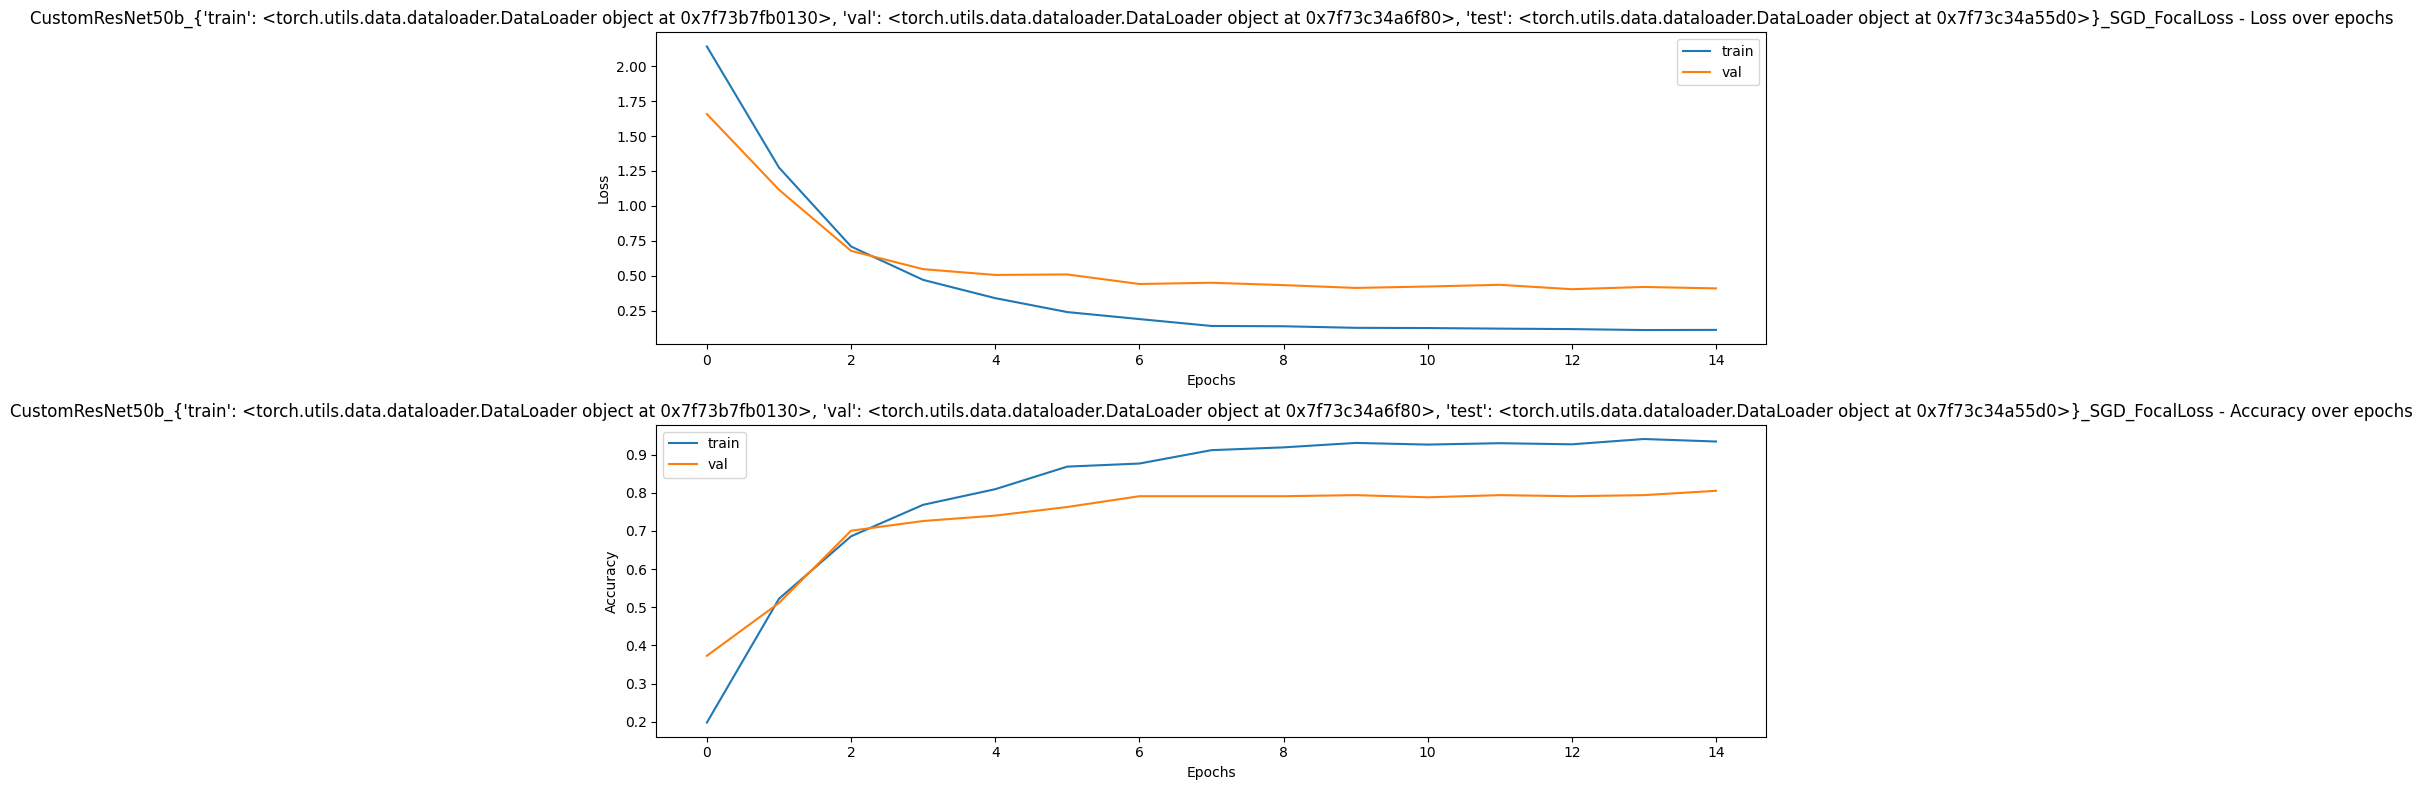


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7fb0130>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a6f80>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a55d0>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.2325 Acc: 0.2703
val Loss: 2.2604 Acc: 0.3164

Epoch 1/14
----------
train Loss: 1.7290 Acc: 0.3988
val Loss: 1.6765 Acc: 0.4068

Epoch 2/14
----------
train Loss: 1.4685 Acc: 0.4711
val Loss: 1.8533 Acc: 0.3701

Epoch 3/14
----------
train Loss: 1.3433 Acc: 0.5186
val Loss: 1.4342 Acc: 0.5311

Epoch 4/14
----------
train Loss: 1.2690 Acc: 0.5369
val Loss: 2.1212 Acc: 0.3588

Epoch 5/14
----------
train Loss: 1.1712 Acc: 0.5610
val Loss: 1.4115 Acc: 0.5000

Epoch 6/14
----------
train Loss: 1.0980 Acc: 0.5990
val Loss: 1.7356 Acc: 0.4576

Epoch 7/14
----------
train Loss: 0.9104 Acc: 0.6676
val Loss: 1.1879 Acc: 0.5960

Epoch 8/14
----------
train Loss: 0.8238 Acc: 0.6866
v

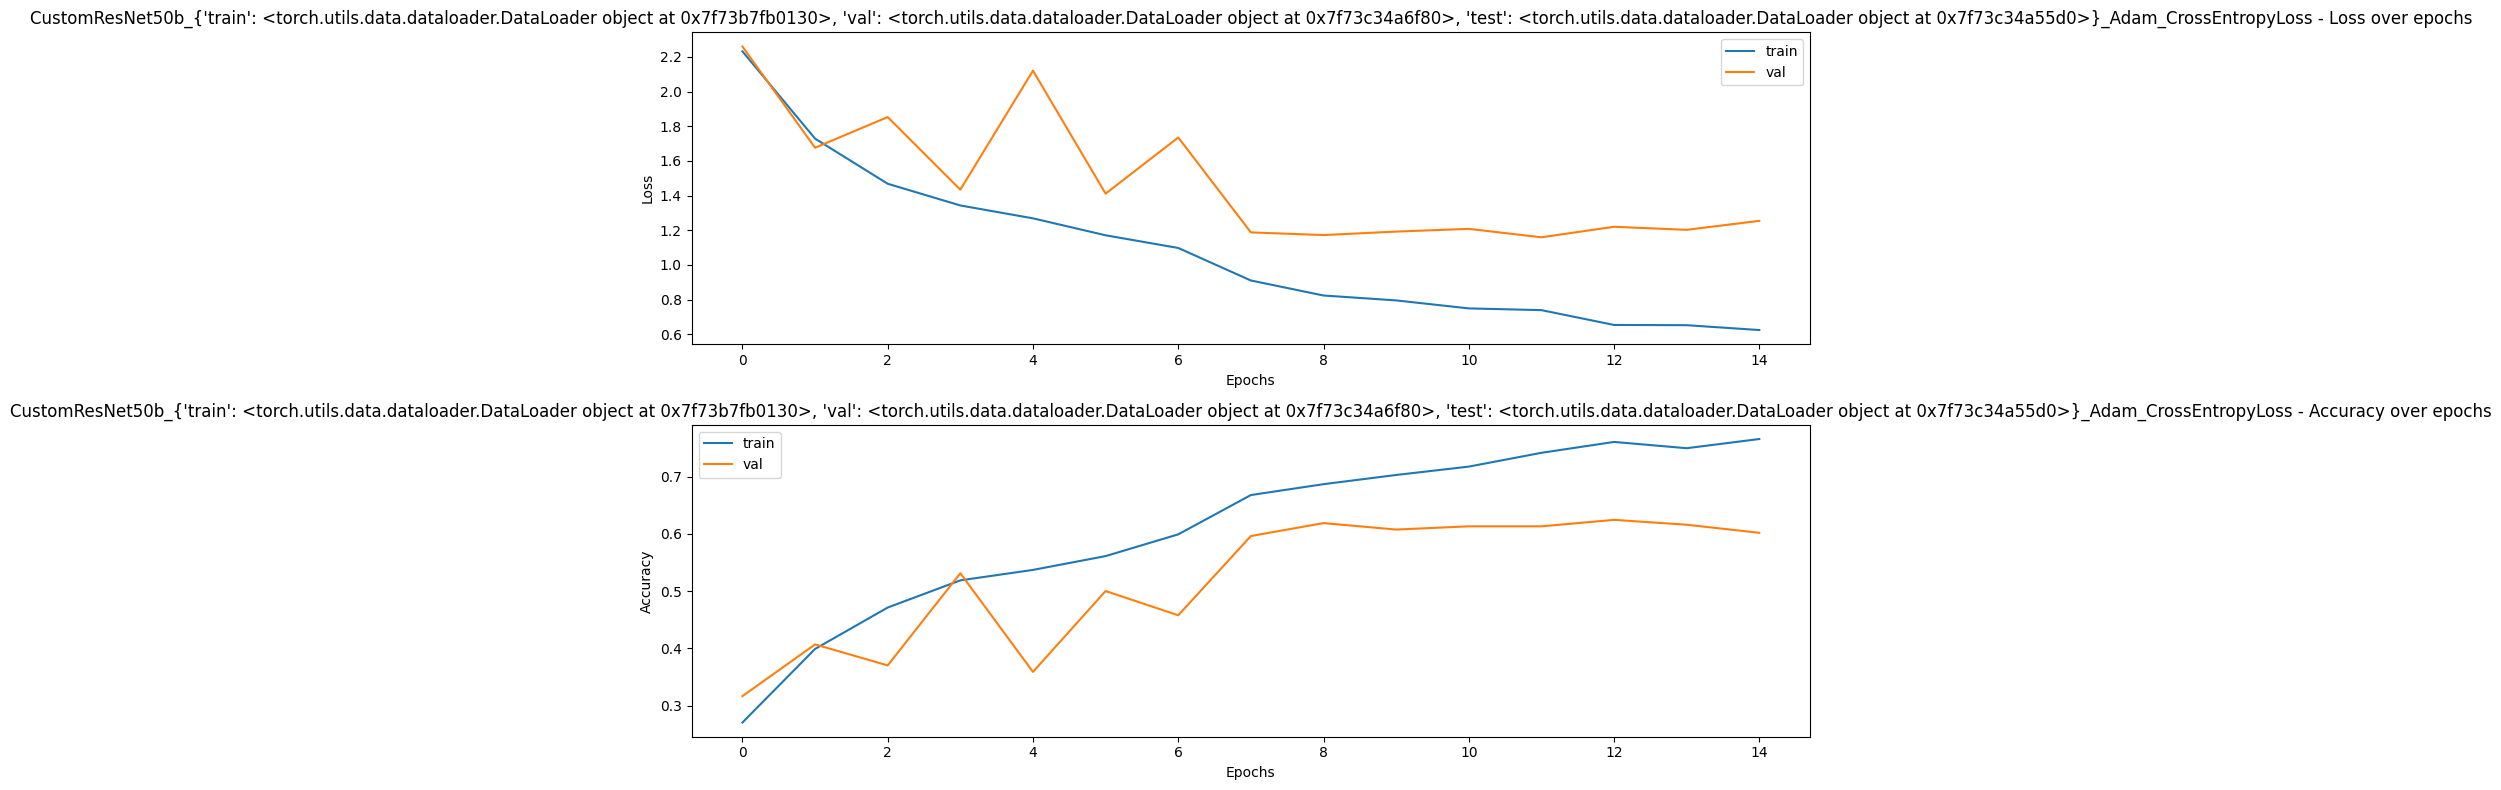


Training with CustomResNet50b, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7fb0130>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a6f80>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a55d0>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.5681 Acc: 0.3389
val Loss: 2.5829 Acc: 0.3164

Epoch 1/14
----------
train Loss: 1.0988 Acc: 0.4755
val Loss: 1.2027 Acc: 0.3785

Epoch 2/14
----------
train Loss: 0.9170 Acc: 0.5055
val Loss: 0.9753 Acc: 0.5311

Epoch 3/14
----------
train Loss: 0.7723 Acc: 0.5588
val Loss: 0.9316 Acc: 0.5085

Epoch 4/14
----------
train Loss: 0.6652 Acc: 0.5909
val Loss: 1.0734 Acc: 0.4548

Epoch 5/14
----------
train Loss: 0.6387 Acc: 0.6114
val Loss: 2.2063 Acc: 0.4011

Epoch 6/14
----------
train Loss: 0.6488 Acc: 0.6238
val Loss: 1.1337 Acc: 0.4859

Epoch 7/14
----------
train Loss: 0.4230 Acc: 0.7159
val Loss: 0.7093 Acc: 0.5847

Epoch 8/14
----------
train Loss: 0.3506 Acc: 0.7261
val Loss

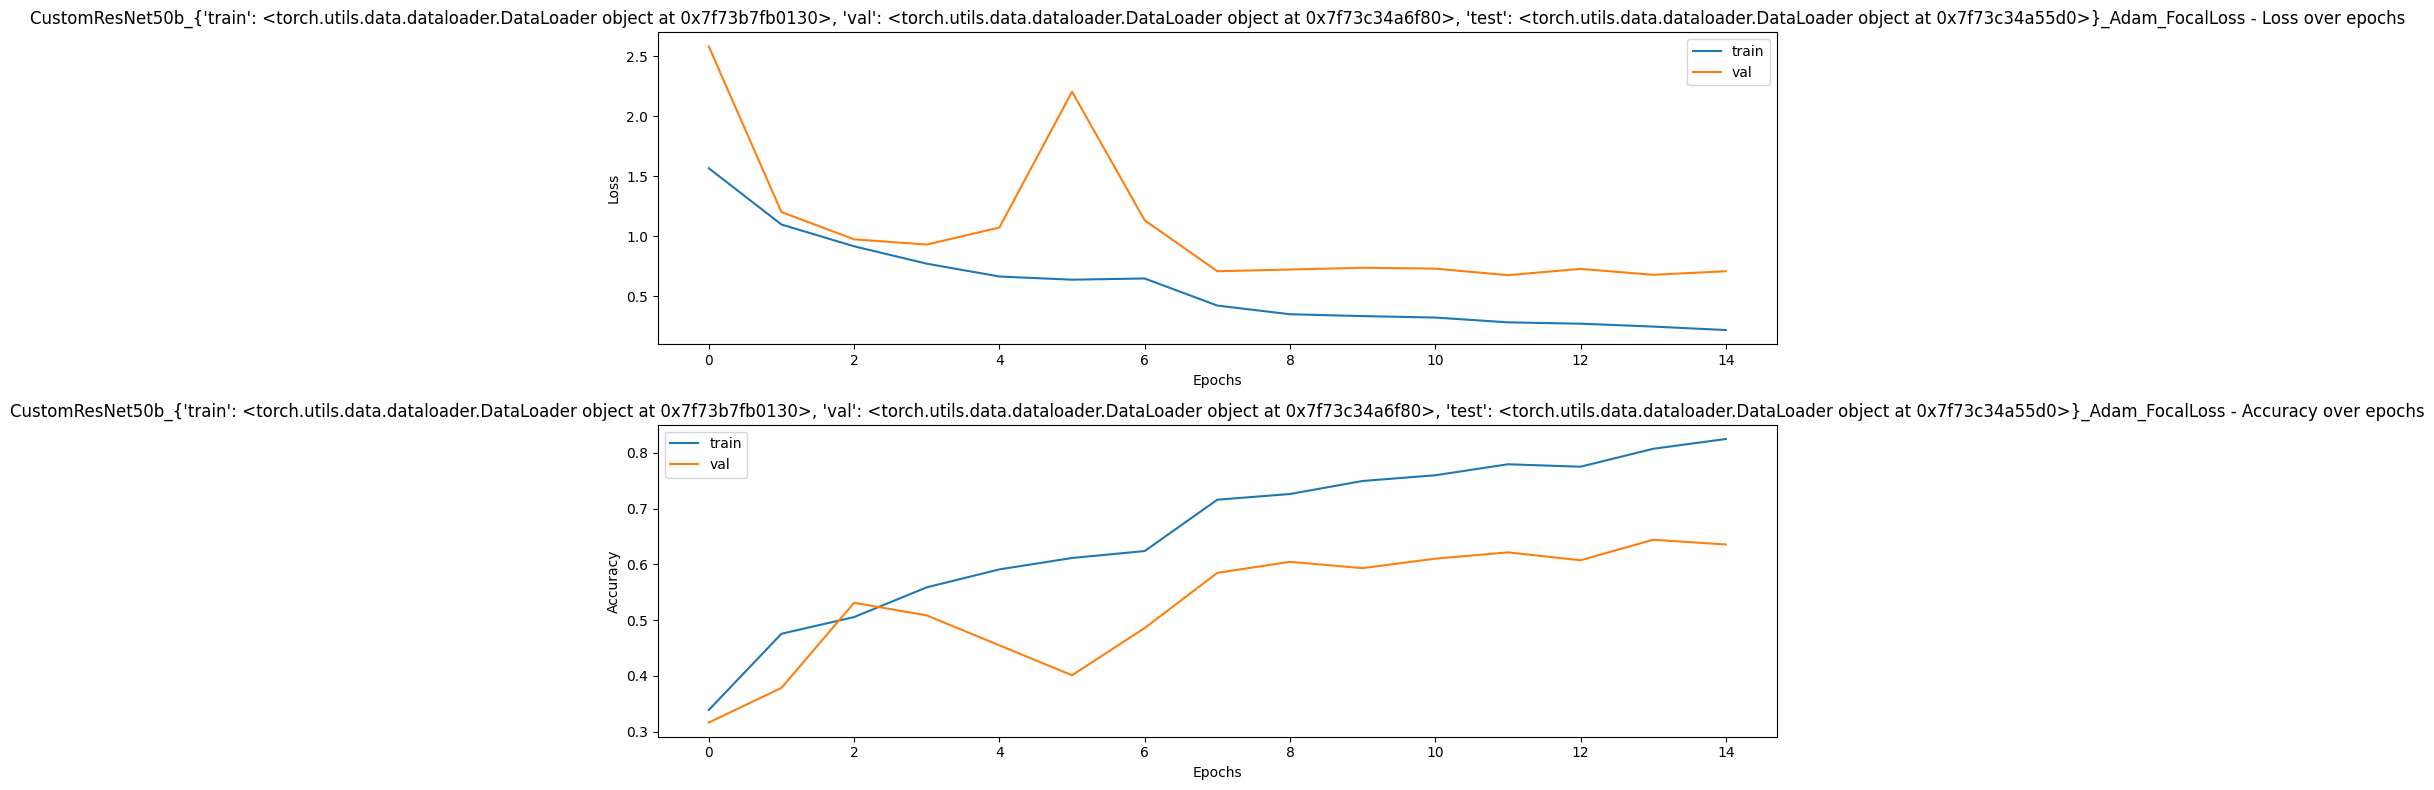

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f44a60>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f45360>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7cc6590>}, SGD, CrossEntropyLoss


100%|██████████| 30.8M/30.8M [00:00<00:00, 384MB/s]


Epoch 0/14
----------
train Loss: 1.9208 Acc: 0.4251
val Loss: 1.2031 Acc: 0.6441

Epoch 1/14
----------
train Loss: 0.8722 Acc: 0.7589
val Loss: 0.8548 Acc: 0.7147

Epoch 2/14
----------
train Loss: 0.5547 Acc: 0.8408
val Loss: 0.6798 Acc: 0.7910

Epoch 3/14
----------
train Loss: 0.3410 Acc: 0.9189
val Loss: 0.5455 Acc: 0.8277

Epoch 4/14
----------
train Loss: 0.2392 Acc: 0.9540
val Loss: 0.5508 Acc: 0.8136

Epoch 5/14
----------
train Loss: 0.1733 Acc: 0.9686
val Loss: 0.5304 Acc: 0.8333

Epoch 6/14
----------
train Loss: 0.1272 Acc: 0.9759
val Loss: 0.5480 Acc: 0.8362

Epoch 7/14
----------
train Loss: 0.0926 Acc: 0.9898
val Loss: 0.5347 Acc: 0.8362

Epoch 8/14
----------
train Loss: 0.0844 Acc: 0.9876
val Loss: 0.5186 Acc: 0.8418

Epoch 9/14
----------
train Loss: 0.0813 Acc: 0.9898
val Loss: 0.5239 Acc: 0.8362

Epoch 10/14
----------
train Loss: 0.0798 Acc: 0.9934
val Loss: 0.5150 Acc: 0.8418

Epoch 11/14
----------
train Loss: 0.0770 Acc: 0.9927
val Loss: 0.5303 Acc: 0.8362

Ep

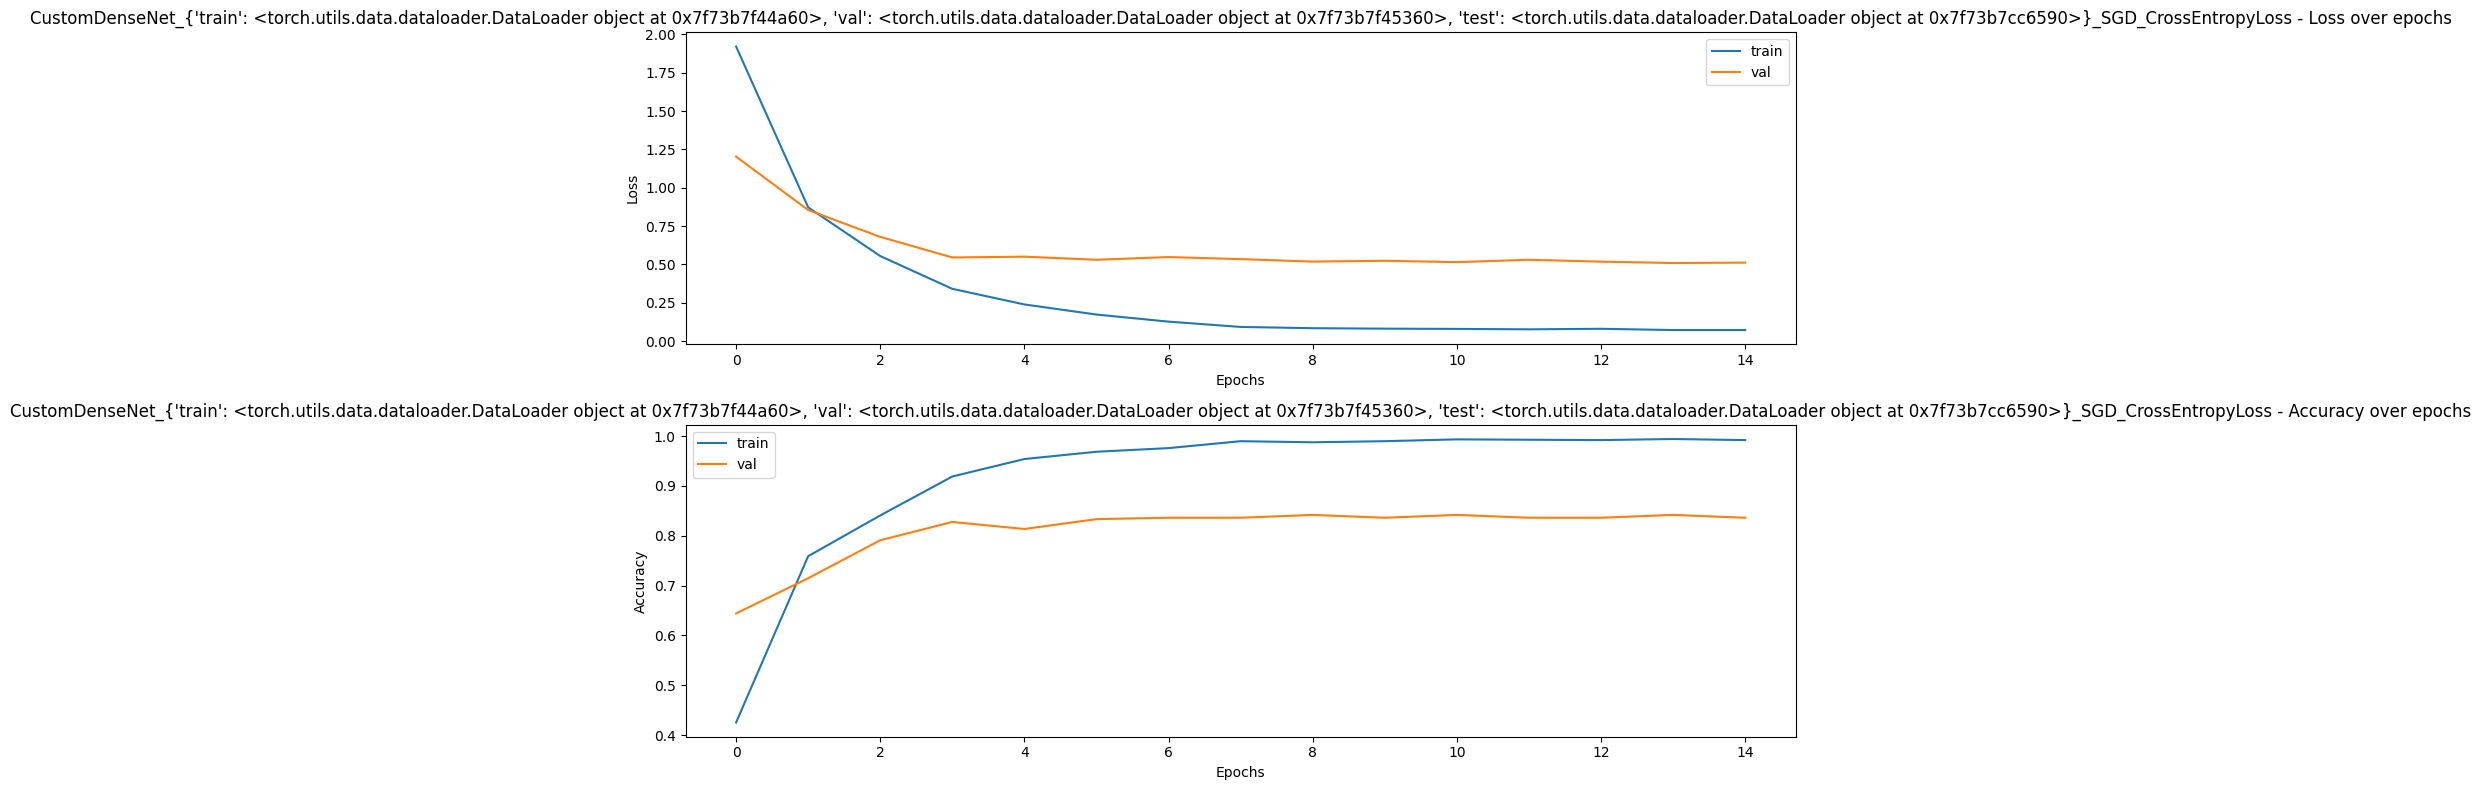


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f44a60>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f45360>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7cc6590>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.3413 Acc: 0.4909
val Loss: 0.7326 Acc: 0.6554

Epoch 1/14
----------
train Loss: 0.4610 Acc: 0.7955
val Loss: 0.4888 Acc: 0.7627

Epoch 2/14
----------
train Loss: 0.2670 Acc: 0.8532
val Loss: 0.4308 Acc: 0.7768

Epoch 3/14
----------
train Loss: 0.1466 Acc: 0.9350
val Loss: 0.3993 Acc: 0.7910

Epoch 4/14
----------
train Loss: 0.0946 Acc: 0.9598
val Loss: 0.3554 Acc: 0.8136

Epoch 5/14
----------
train Loss: 0.0636 Acc: 0.9715
val Loss: 0.3578 Acc: 0.8079

Epoch 6/14
----------
train Loss: 0.0425 Acc: 0.9832
val Loss: 0.3830 Acc: 0.7881

Epoch 7/14
----------
train Loss: 0.0300 Acc: 0.9934
val Loss: 0.3697 Acc: 0.7994

Epoch 8/14
----------
train Loss: 0.0291 Acc: 0.9942
val Loss: 

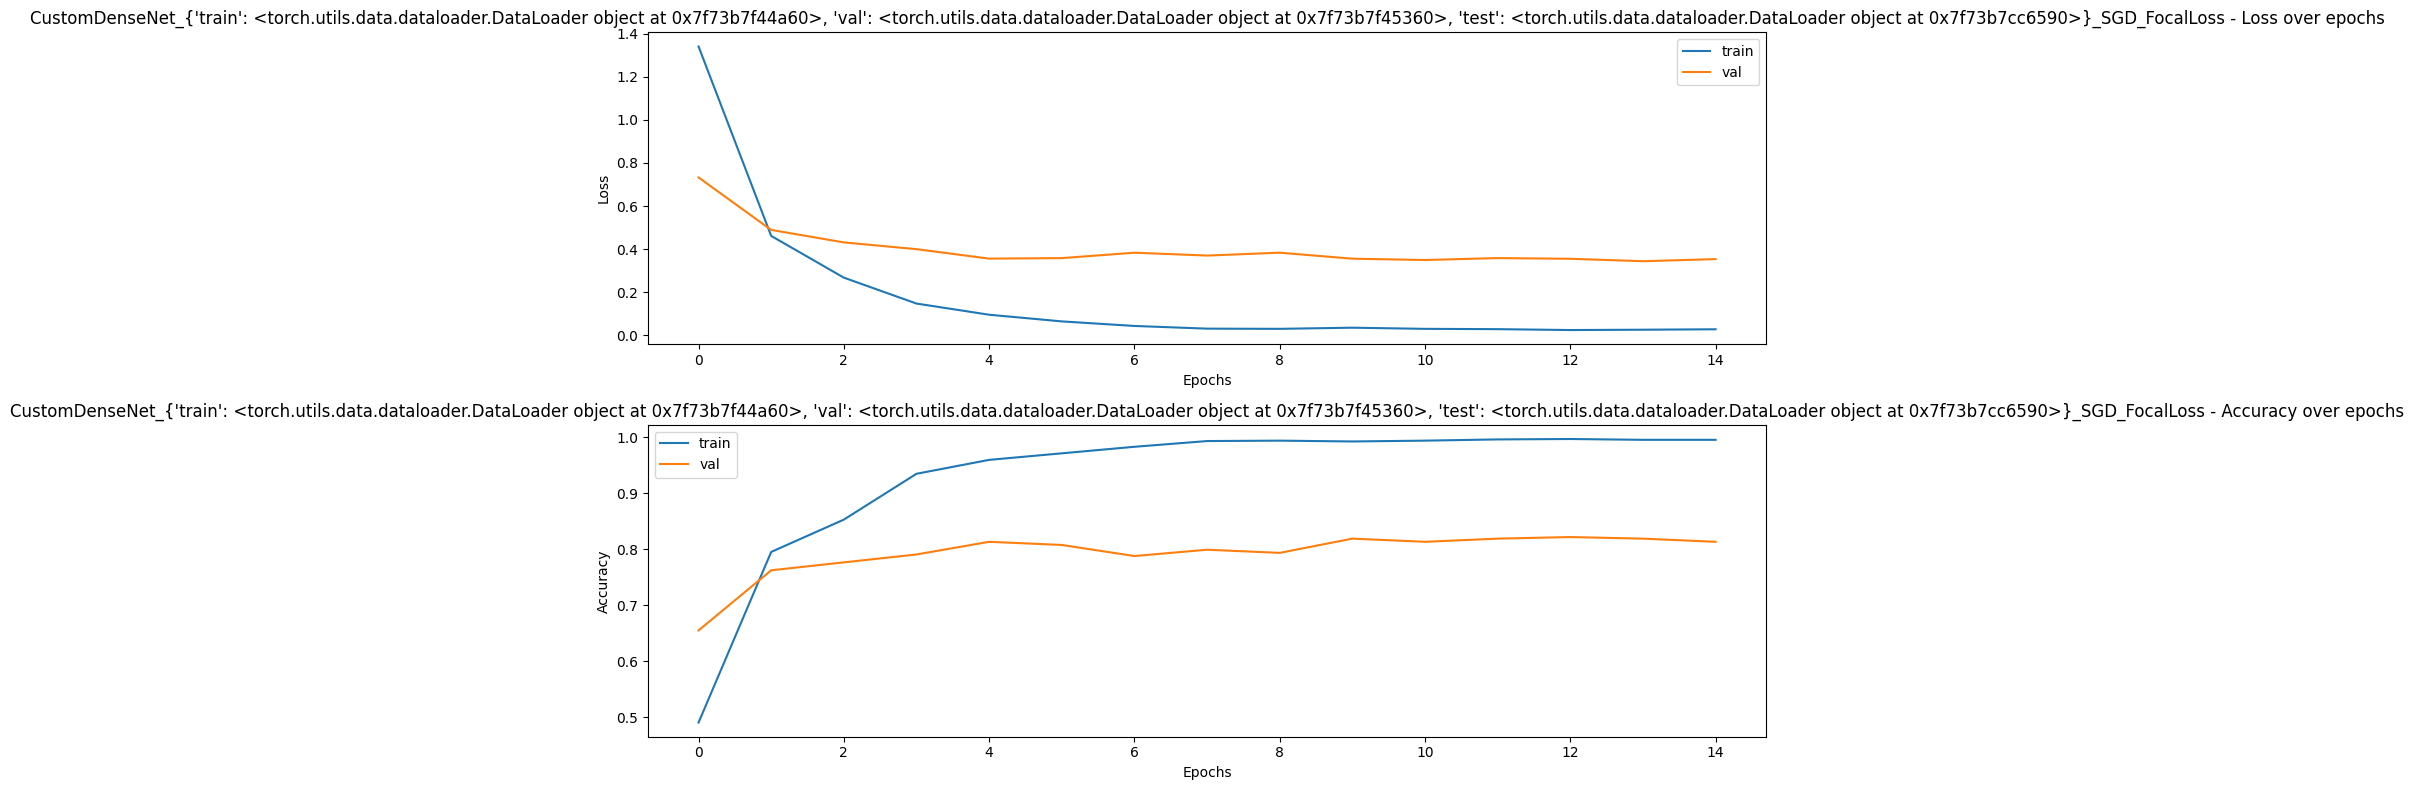


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f44a60>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f45360>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7cc6590>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.2857 Acc: 0.6026
val Loss: 1.7785 Acc: 0.5706

Epoch 1/14
----------
train Loss: 0.7850 Acc: 0.7575
val Loss: 1.1639 Acc: 0.6554

Epoch 2/14
----------
train Loss: 0.6062 Acc: 0.7889
val Loss: 1.0468 Acc: 0.6610

Epoch 3/14
----------
train Loss: 0.4786 Acc: 0.8444
val Loss: 0.8218 Acc: 0.7345

Epoch 4/14
----------
train Loss: 0.4103 Acc: 0.8685
val Loss: 0.7448 Acc: 0.7599

Epoch 5/14
----------
train Loss: 0.3304 Acc: 0.8926
val Loss: 0.8510 Acc: 0.7797

Epoch 6/14
----------
train Loss: 0.2791 Acc: 0.9028
val Loss: 1.3005 Acc: 0.7062

Epoch 7/14
----------
train Loss: 0.1528 Acc: 0.9511
val Loss: 0.4706 Acc: 0.8672

Epoch 8/14
----------
train Loss: 0.0795 Acc: 0.9795
va

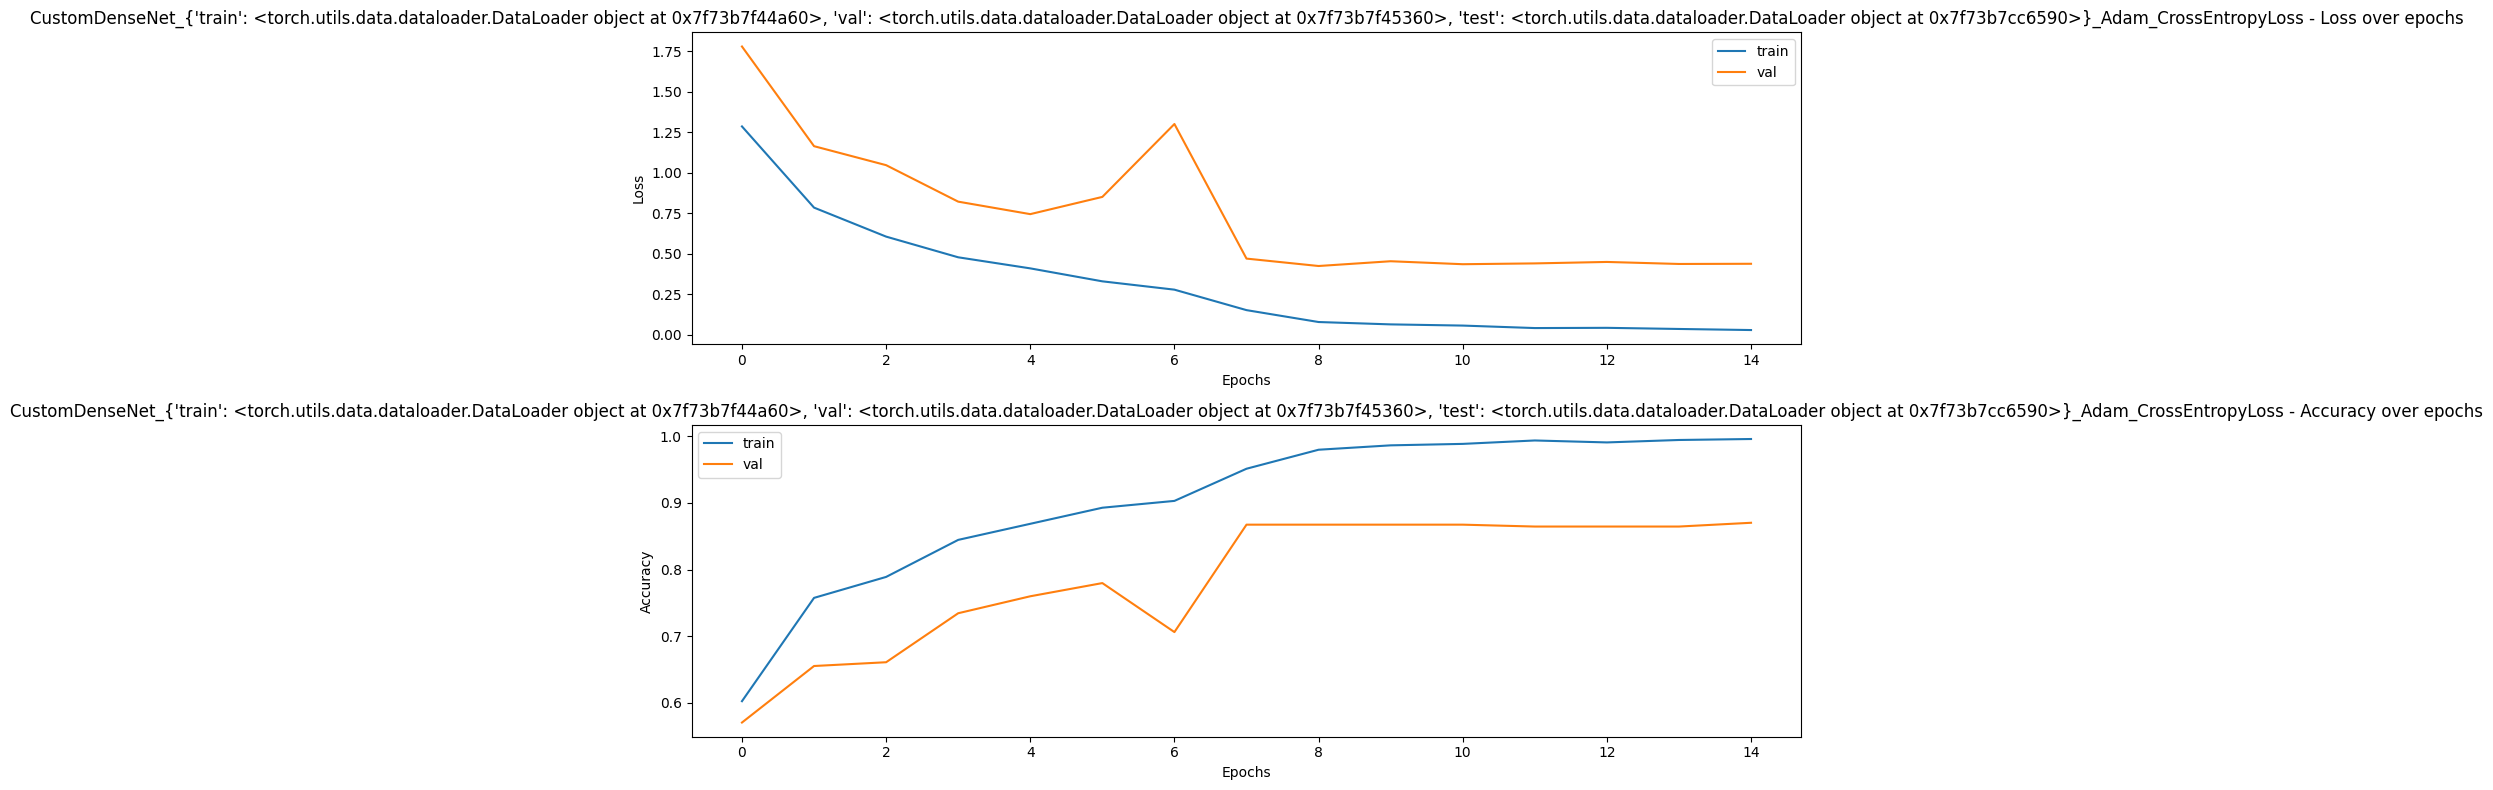


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f44a60>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7f45360>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7cc6590>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 0.8721 Acc: 0.6275
val Loss: 4.9279 Acc: 0.2853

Epoch 1/14
----------
train Loss: 0.5436 Acc: 0.7137
val Loss: 0.9049 Acc: 0.5395

Epoch 2/14
----------
train Loss: 0.3659 Acc: 0.7838
val Loss: 0.9854 Acc: 0.6412

Epoch 3/14
----------
train Loss: 0.2895 Acc: 0.8262
val Loss: 1.0660 Acc: 0.6102

Epoch 4/14
----------
train Loss: 0.1860 Acc: 0.8619
val Loss: 0.9976 Acc: 0.6610

Epoch 5/14
----------
train Loss: 0.2320 Acc: 0.8576
val Loss: 1.7721 Acc: 0.5311

Epoch 6/14
----------
train Loss: 0.1802 Acc: 0.8627
val Loss: 0.4643 Acc: 0.7684

Epoch 7/14
----------
train Loss: 0.0810 Acc: 0.9328
val Loss: 0.2329 Acc: 0.8503

Epoch 8/14
----------
train Loss: 0.0410 Acc: 0.9693
val Loss:

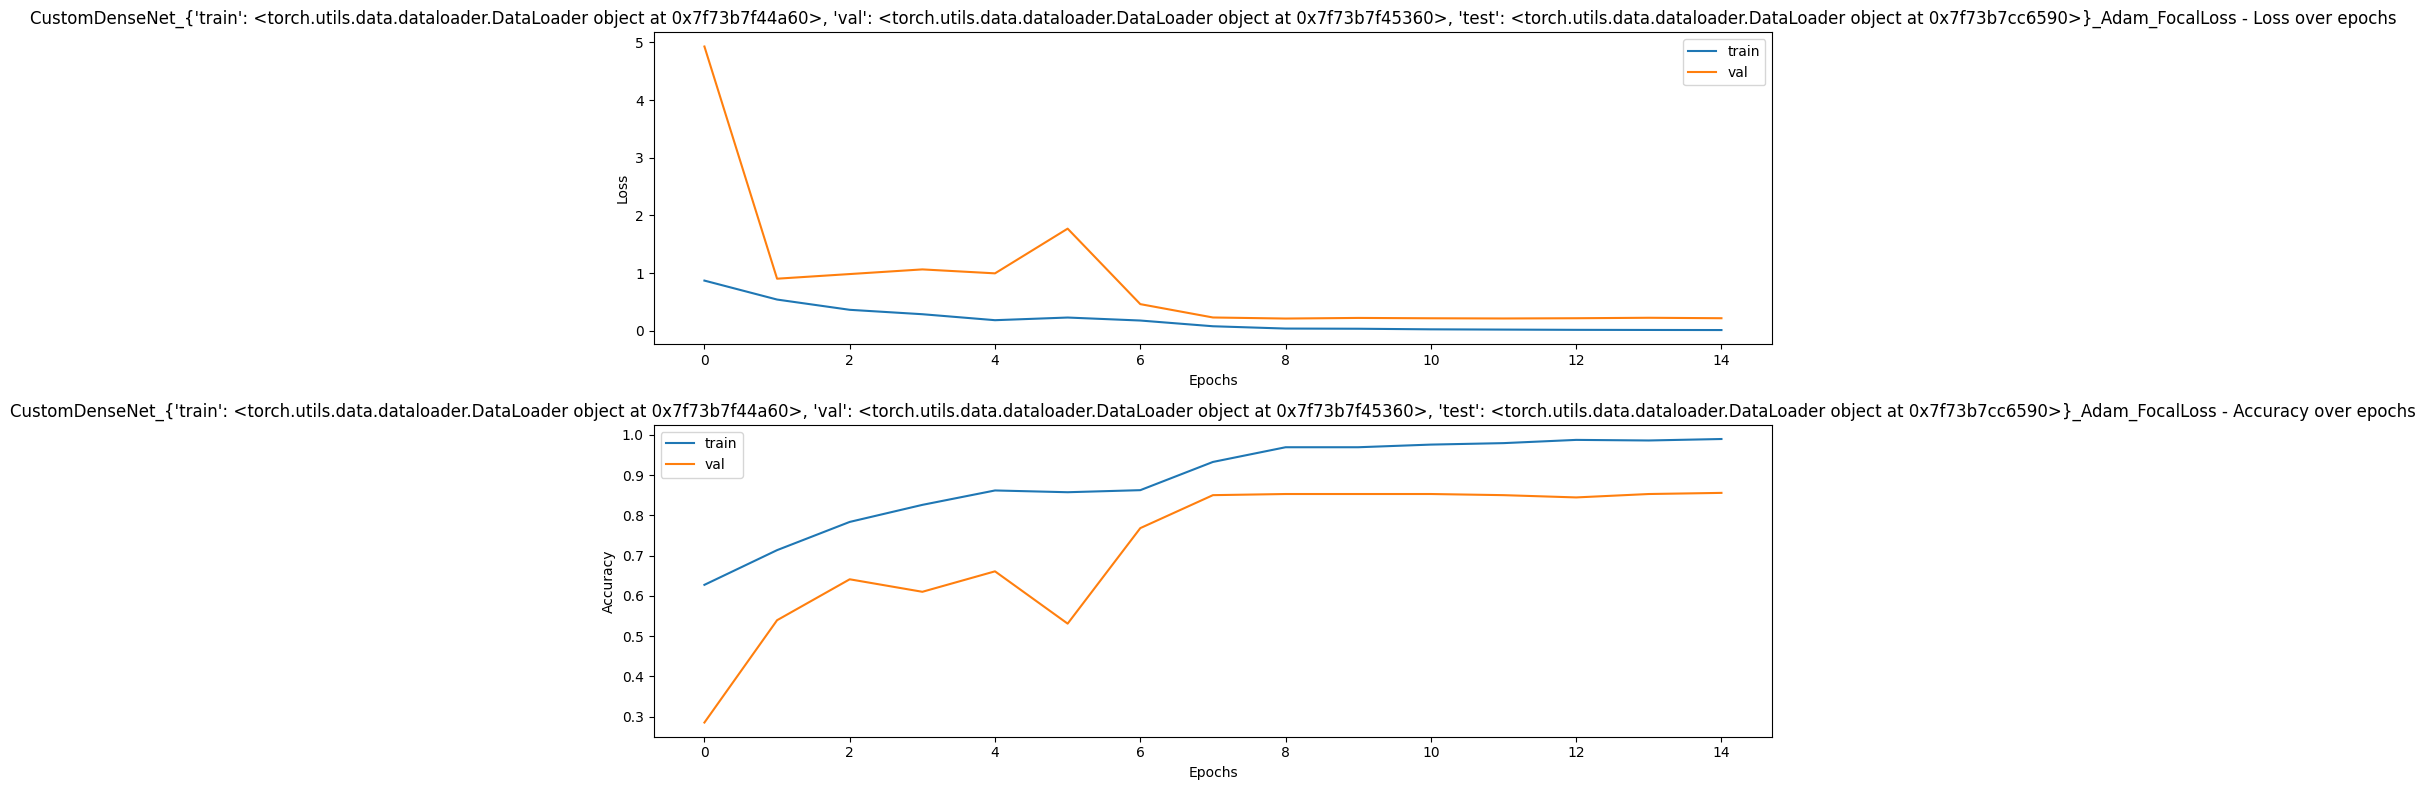


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7fb0130>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a6f80>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a55d0>}, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9053 Acc: 0.4427
val Loss: 1.2357 Acc: 0.6667

Epoch 1/14
----------
train Loss: 0.9538 Acc: 0.7385
val Loss: 0.8970 Acc: 0.7401

Epoch 2/14
----------
train Loss: 0.6282 Acc: 0.8137
val Loss: 0.7606 Acc: 0.7768

Epoch 3/14
----------
train Loss: 0.4436 Acc: 0.8649
val Loss: 0.6106 Acc: 0.8164

Epoch 4/14
----------
train Loss: 0.3402 Acc: 0.9028
val Loss: 0.5796 Acc: 0.8220

Epoch 5/14
----------
train Loss: 0.2680 Acc: 0.9299
val Loss: 0.5239 Acc: 0.8362

Epoch 6/14
----------
train Loss: 0.1884 Acc: 0.9554
val Loss: 0.5323 Acc: 0.8333

Epoch 7/14
----------
train Loss: 0.1488 Acc: 0.9737
val Loss: 0.5574 Acc: 0.8362

Epoch 8/14
----------
train Loss: 0.1341 Acc: 0.9795
val

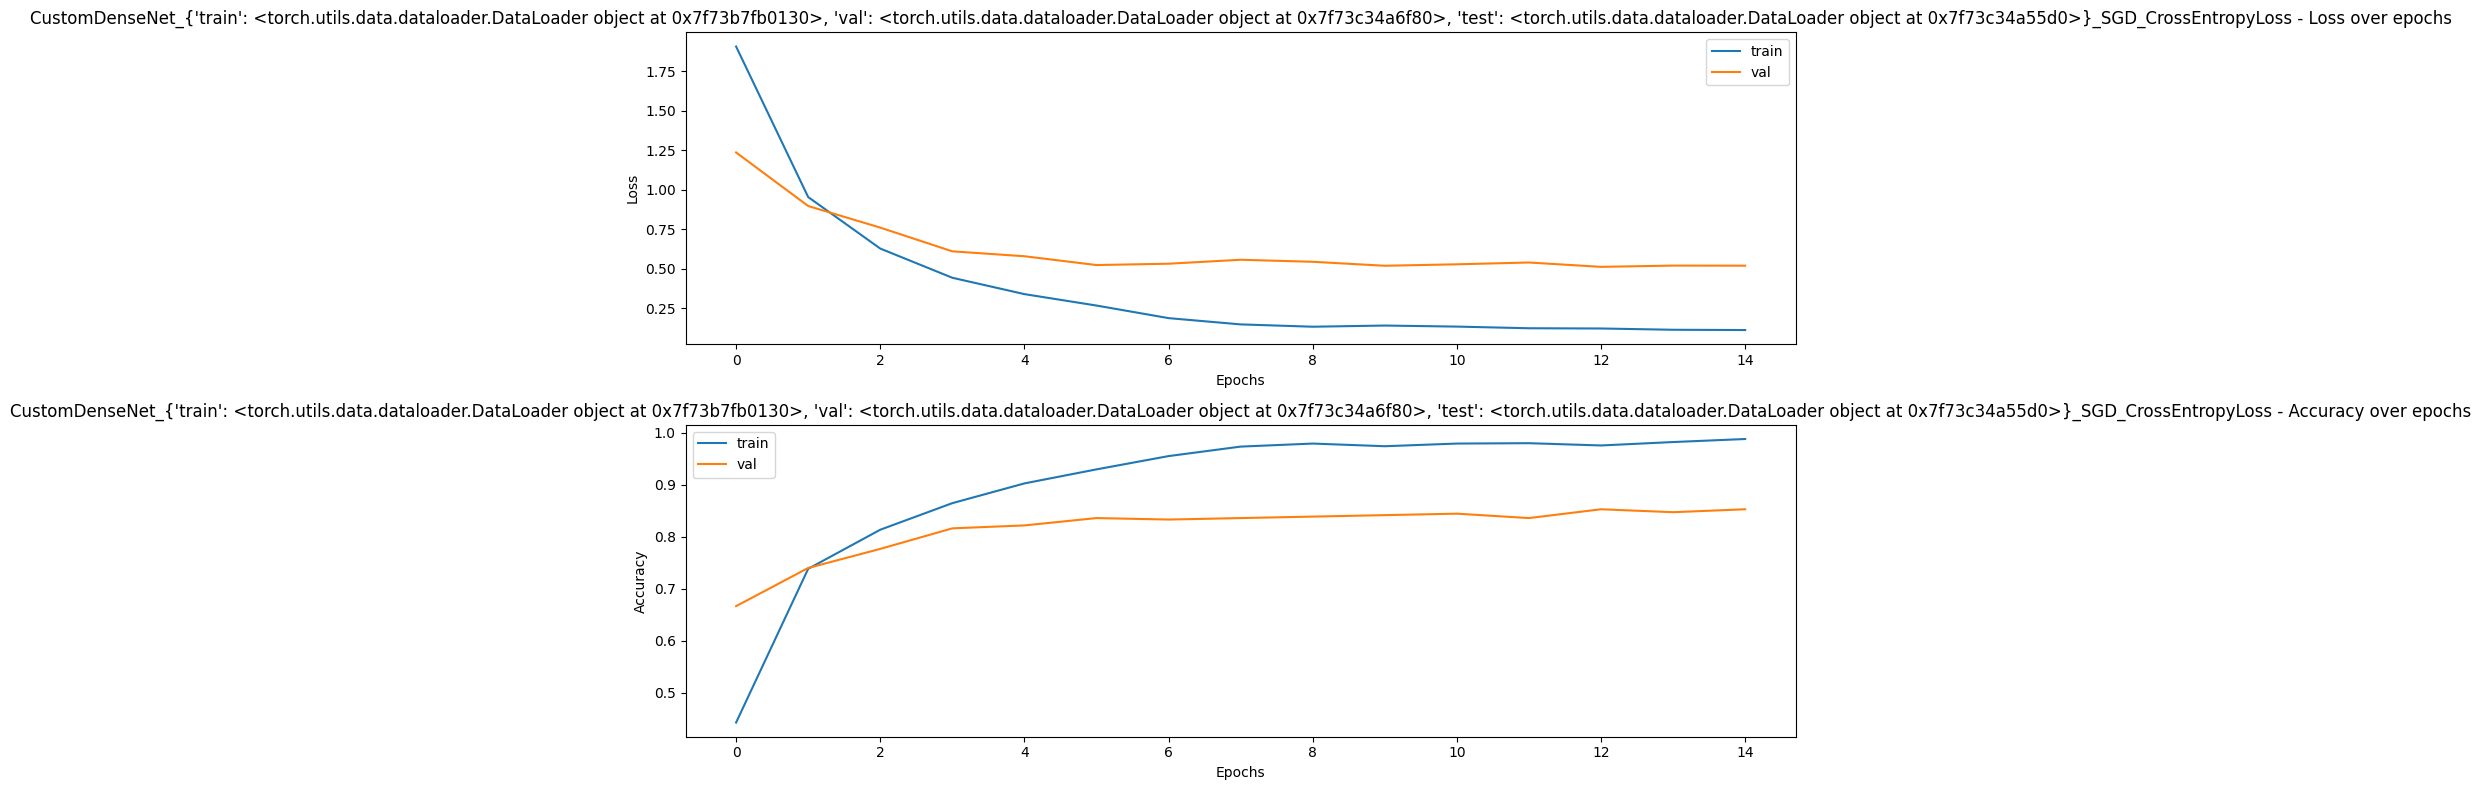


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7fb0130>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a6f80>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a55d0>}, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.4514 Acc: 0.4646
val Loss: 0.7724 Acc: 0.6356

Epoch 1/14
----------
train Loss: 0.5477 Acc: 0.7327
val Loss: 0.5263 Acc: 0.7345

Epoch 2/14
----------
train Loss: 0.3294 Acc: 0.8415
val Loss: 0.4622 Acc: 0.7542

Epoch 3/14
----------
train Loss: 0.2122 Acc: 0.8795
val Loss: 0.3746 Acc: 0.7994

Epoch 4/14
----------
train Loss: 0.1587 Acc: 0.9167
val Loss: 0.3997 Acc: 0.7994

Epoch 5/14
----------
train Loss: 0.1002 Acc: 0.9511
val Loss: 0.3629 Acc: 0.8277

Epoch 6/14
----------
train Loss: 0.0791 Acc: 0.9569
val Loss: 0.3611 Acc: 0.8220

Epoch 7/14
----------
train Loss: 0.0550 Acc: 0.9803
val Loss: 0.3382 Acc: 0.8475

Epoch 8/14
----------
train Loss: 0.0523 Acc: 0.9766
val Loss: 

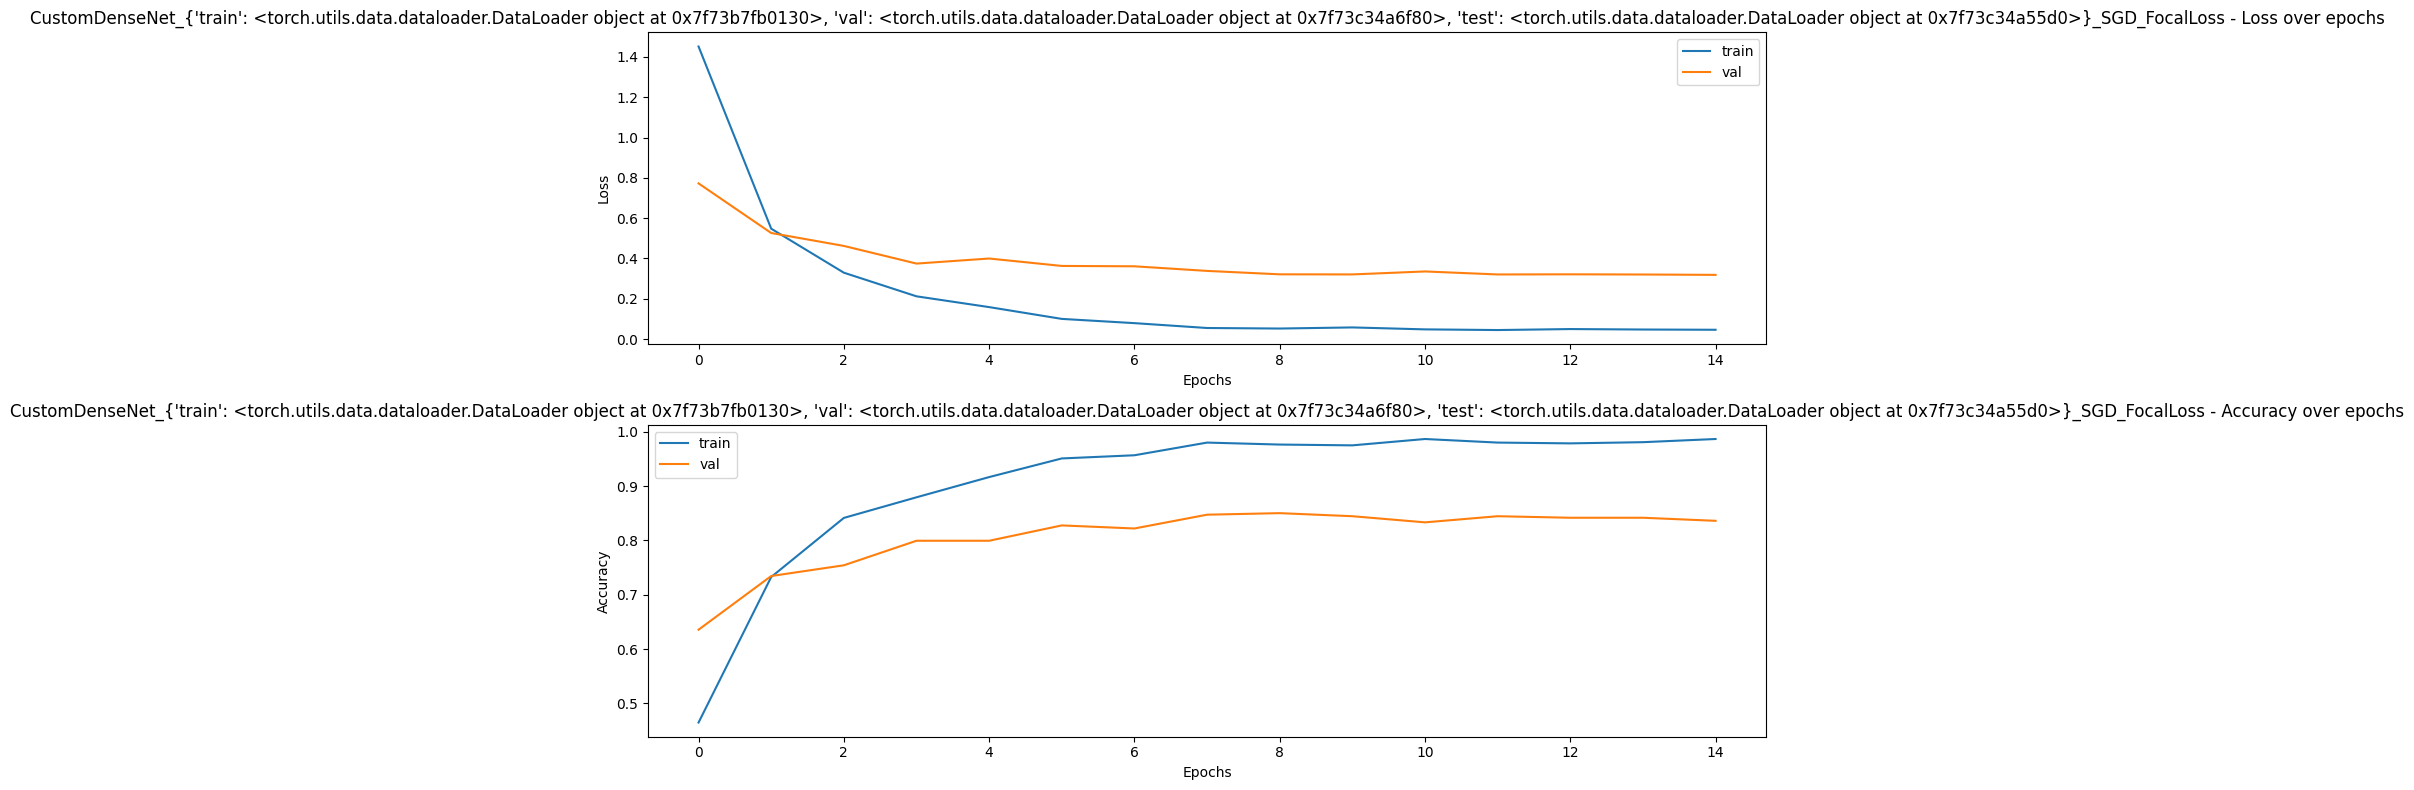


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7fb0130>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a6f80>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a55d0>}, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.4786 Acc: 0.5464
val Loss: 1.7761 Acc: 0.4802

Epoch 1/14
----------
train Loss: 0.9767 Acc: 0.6852
val Loss: 1.0843 Acc: 0.6441

Epoch 2/14
----------
train Loss: 0.6981 Acc: 0.7750
val Loss: 1.3668 Acc: 0.5791

Epoch 3/14
----------
train Loss: 0.6192 Acc: 0.8042
val Loss: 0.8543 Acc: 0.7260

Epoch 4/14
----------
train Loss: 0.4814 Acc: 0.8342
val Loss: 0.8250 Acc: 0.7684

Epoch 5/14
----------
train Loss: 0.4359 Acc: 0.8510
val Loss: 1.3795 Acc: 0.6582

Epoch 6/14
----------
train Loss: 0.4324 Acc: 0.8554
val Loss: 0.9630 Acc: 0.7062

Epoch 7/14
----------
train Loss: 0.2061 Acc: 0.9328
val Loss: 0.4754 Acc: 0.8503

Epoch 8/14
----------
train Loss: 0.1505 Acc: 0.9554
va

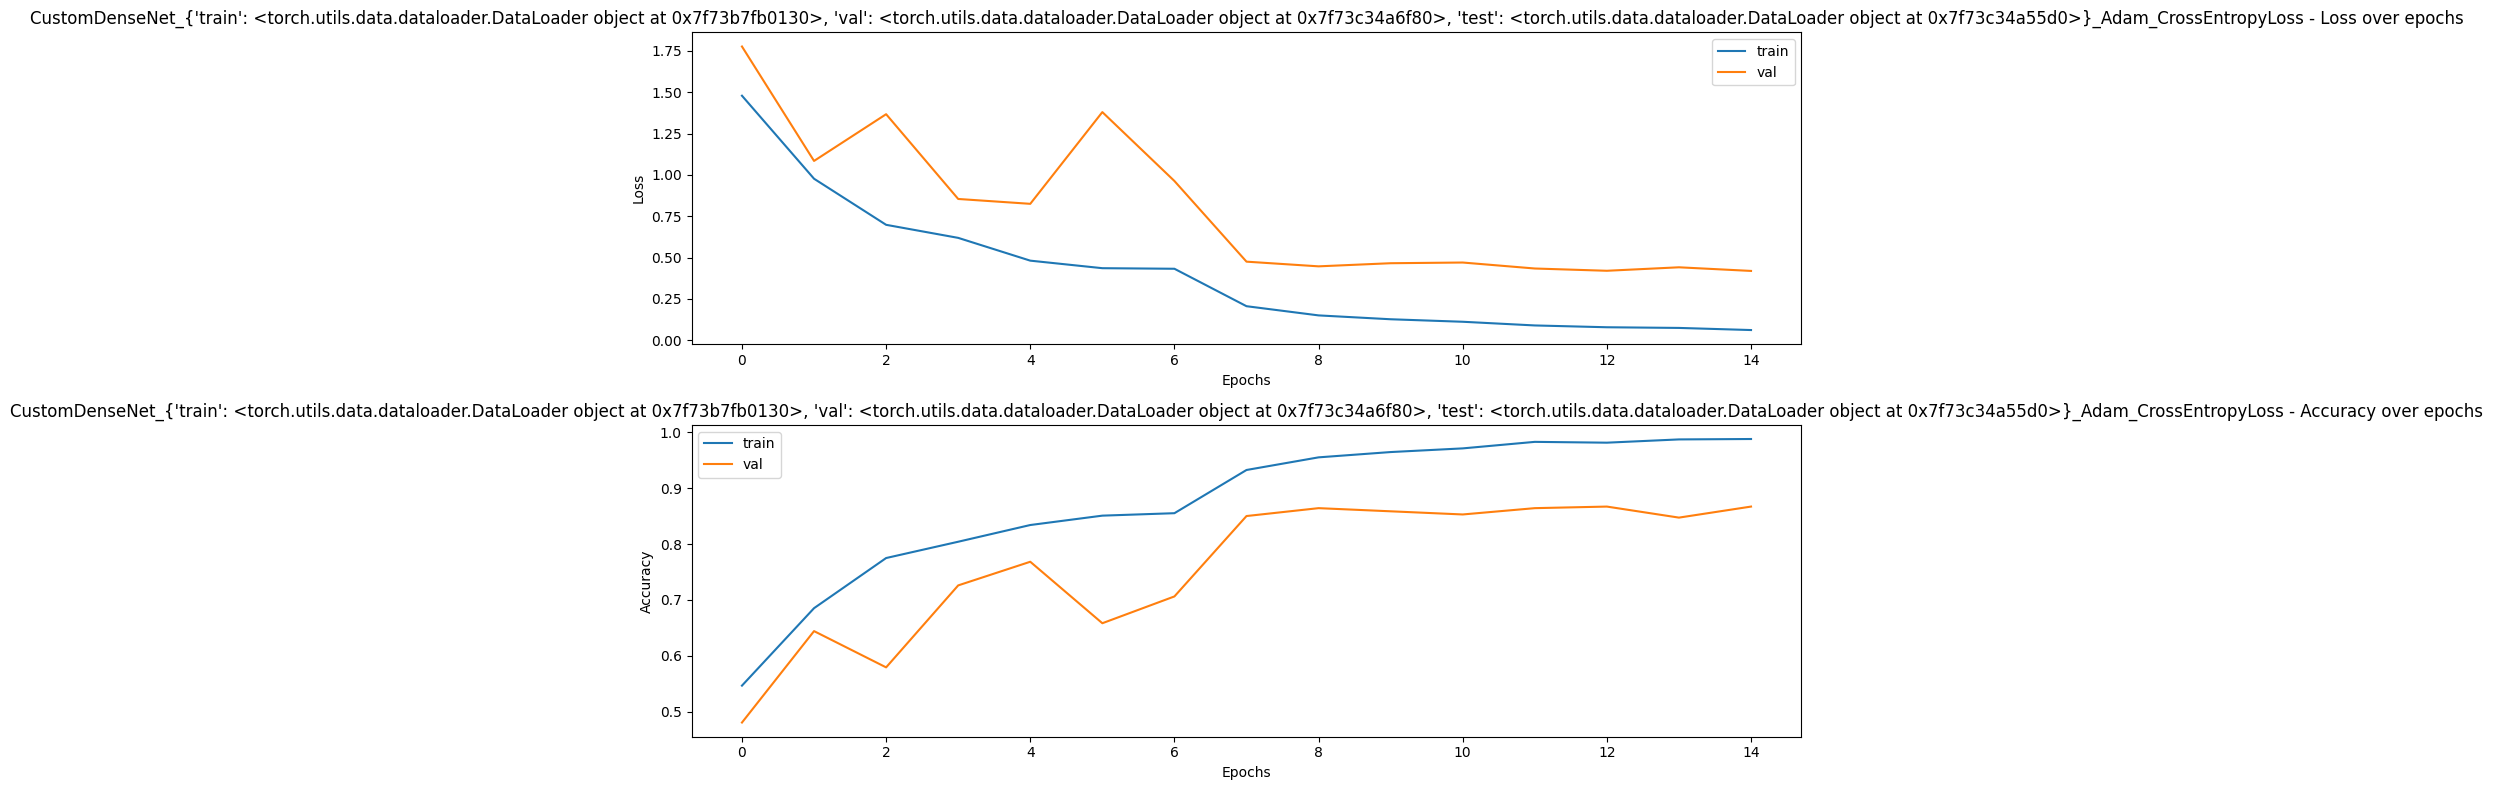


Training with CustomDenseNet, {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f73b7fb0130>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a6f80>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f73c34a55d0>}, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.0209 Acc: 0.5457
val Loss: 2.0826 Acc: 0.4520

Epoch 1/14
----------
train Loss: 0.6149 Acc: 0.7027
val Loss: 0.7328 Acc: 0.6497

Epoch 2/14
----------
train Loss: 0.4450 Acc: 0.7684
val Loss: 0.7043 Acc: 0.7175

Epoch 3/14
----------
train Loss: 0.3072 Acc: 0.8181
val Loss: 0.5833 Acc: 0.7288

Epoch 4/14
----------
train Loss: 0.3204 Acc: 0.8050
val Loss: 0.8368 Acc: 0.6695

Epoch 5/14
----------
train Loss: 0.2267 Acc: 0.8386
val Loss: 0.5163 Acc: 0.7458

Epoch 6/14
----------
train Loss: 0.2241 Acc: 0.8539
val Loss: 0.5631 Acc: 0.7373

Epoch 7/14
----------
train Loss: 0.1281 Acc: 0.9014
val Loss: 0.3285 Acc: 0.8333

Epoch 8/14
----------
train Loss: 0.0534 Acc: 0.9598
val Loss:

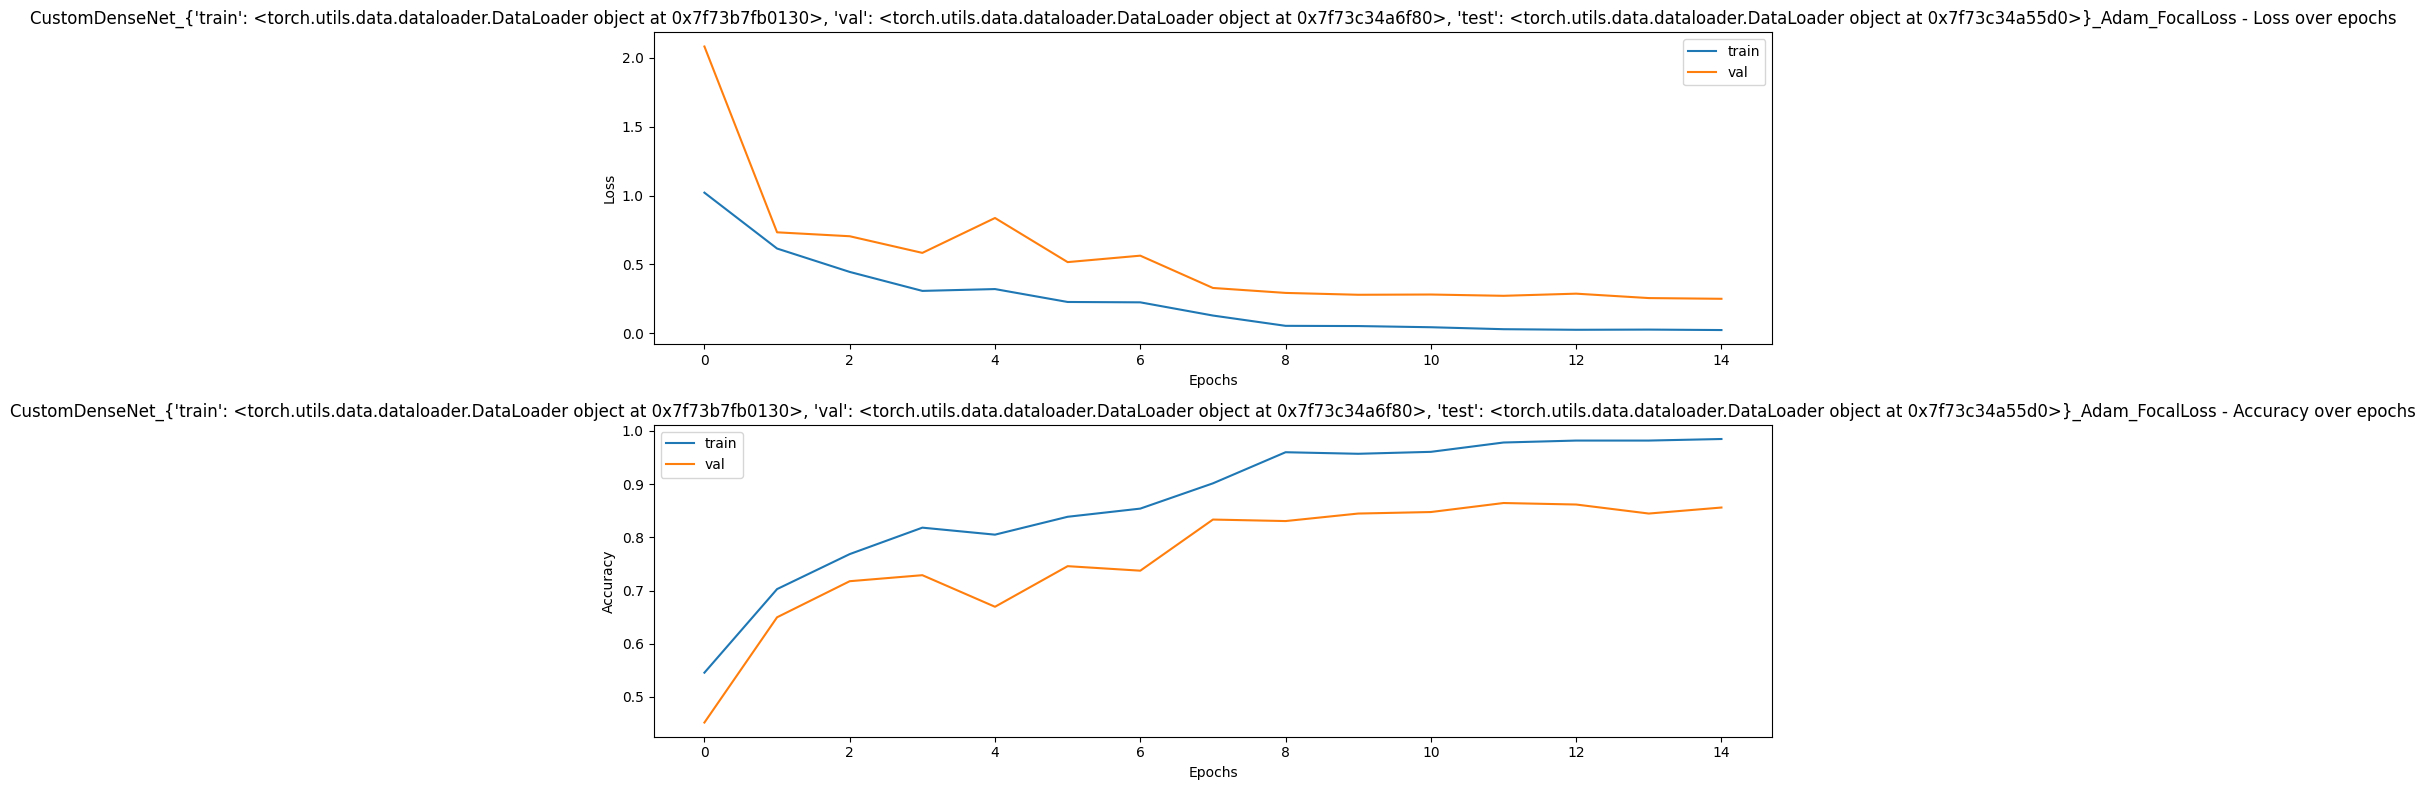

In [9]:
# perform several training runs to compare accuracy on the validation dataset
best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_accuracy = best_val_accuracy
               

In [10]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):
   

    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)
  
    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    
    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("/content/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      



[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           2       0.90      0.90      0.90        49
           6       0.88      1.00      0.93        14
           7       0.95      1.00      0.97        18
           8       0.97      0.94      0.96        35
           9       0.97      0.94      0.96        34
          11       1.00      0.95      0.97        20
          12       0.00      0.00      0.00        12
          13       1.00      0.33      0.50         3
          14       0.83      1.00      0.90        19
          16       0.60      0.60      0.60        20
          17       1.00      0.94      0.97        17
          18       1.00      0.95      0.98        22
          19       0.94      0.89      0.92        19
          23       0.46      0.58      0.51        19
          25       0.79   

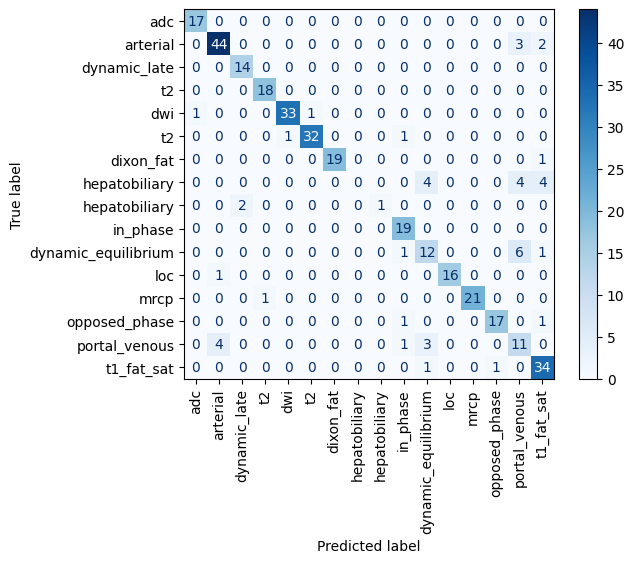

<Figure size 2500x2500 with 0 Axes>

In [11]:
# Evaluate the model on the val dataset
model = best_model

model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(val_predictions, val_labels, classes, fn='DenseNetFL', saveflag=True)

# Save the trained model if needed
save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
torch.save(trained_model.state_dict(), '/content/gdrive/MyDrive/model0530b.pth')



# model.eval()
# val_predictions = []
# test_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     print(labels)
#     with torch.no_grad(): # No need to calculate gradients when doing inference
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1) # Get class from network's prediction
#         test_predictions.append(predicted.cpu().numpy())
#         test_labels.append(labels.cpu().numpy())

# print (test_predictions)
# print(test_labels)


# test_predictions = np.concatenate(test_predictions, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)


# accuracy = np.sum(test_predictions==test_labels)/len(test_labels)
# print('Accuracy on the test dataset is ', np.round(accuracy, 3))
# #results = make_results_df(preds, true, test)

# # Save the trained model if needed
# save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
# torch.save(trained_model.state_dict(), save_filename)


In [ ]:
torch.save(trained_model.state_dict(), '/content/model0529a.pth')


In [12]:
!pip install transformers
from transformers import DeiTFeatureExtractor, DeiTForImageClassification



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
batch_size = 16

optimizer = optim.Adam(deit_model.parameters(), lr=0.001, betas=(0.9,0.99))
criterion = FocalLoss()


def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    if min_val != max_val:
        image = (image - min_val) / (max_val - min_val)
    else:
        # Avoid zero division and return a zero image.
        image = torch.zeros_like(image)
    return image

class ImgDataset_deit(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform
        
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
      source = file_dict['img_data_dir_local']
      dest = file_dict['img_data_dir_colab']

      img_file = self.data_df.fname[idx]
      ds = pydicom.dcmread(img_file)
      img = ds.pixel_array.astype(np.float32)  # Convert to float
      img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize here
      print('img min:', np.min(img), 'img max:', np.max(img))
      img = torch.from_numpy(img)  # Convert to torch tensor
      img = img.repeat(3, 1, 1)  # Convert to 3-channel image

      if self.transform:
        img = self.transform(img)

      img = img[np.newaxis]
      # Apply feature extractor directly here
      img = feature_extractor(images=img, return_tensors="pt")["pixel_values"]
      print('now img min is ', np.min(img), 'img max is ', np.max(img))

      labl = self.data_df.label[idx]
      adjusted_label = classes.index(labl)
      y = torch.tensor(adjusted_label, dtype=torch.long) 

      return (img, y)



deit_transforms = {
    'train': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
]),
    'val': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ]),

    'test': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ])
}

def get_data_loaders_deit(train, val, test, batch_size, data_transforms = deit_transforms, shuffle=True, num_workers=0):
    # Create instances of your custom dataset
    train_imgdata = ImgDataset_deit(train, data_transforms['train'])
    val_imgdata = ImgDataset_deit(val, data_transforms['val'])
    test_imgdata = ImgDataset_deit(test, data_transforms['test'])

    # Create data loaders for the training, validation, and test datasets
    train_loader = DataLoader(train_imgdata, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_imgdata, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    test_loader = DataLoader(test_imgdata, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    dataset_sizes = {'train': len(train_imgdata), 'val': len(val_imgdata)}

    return train_loader, val_loader, test_loader, dataset_sizes








train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=deit_transforms)



Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['distillation_classifier.bias', 'distillation_classifier.weight', 'cls_classifier.weight', 'cls_classifier.bias']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream t

In [14]:
def calc_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels.data)


In [15]:
def train_deit_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.logits, labels)
                    _, preds = torch.max(outputs.logits, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


In [ ]:
deit_model = deit_model.to(device)
deit_model, train_acc, val_acc, train_loss, val_loss = train_deit_model(deit_model, {'train': train_loader_deit, 'val': val_loader_deit}, criterion, optimizer, num_epochs=25)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss.cpu(), label='Training Loss')
plt.plot(val_loss.cpu(), label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_acc.cpu(), label='Training Accuracy')
plt.plot(val_acc.cpu(), label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


Epoch 0/24
----------
train Loss: 0.5054 Acc: 0.6779
val Loss: 1.7511 Acc: 0.3588

Epoch 1/24
----------
train Loss: 0.4954 Acc: 0.6954
val Loss: 1.6133 Acc: 0.3955

Epoch 2/24
----------
train Loss: 0.4363 Acc: 0.6954
val Loss: 1.5550 Acc: 0.4011

Epoch 3/24
----------
train Loss: 0.4374 Acc: 0.7093
val Loss: 1.7068 Acc: 0.4322

Epoch 4/24
----------
train Loss: 0.4303 Acc: 0.7012
val Loss: 1.5294 Acc: 0.3729

Epoch 5/24
----------
train Loss: 0.3918 Acc: 0.7180
val Loss: 1.7045 Acc: 0.3927

Epoch 6/24
----------


In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained DeiT model and adjust the classifier for your number of classes
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
num_classes = len(classes) # classes is your list of classes
deit_model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
deit_model.to(device)

# Define your loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deit_model.parameters(), lr=0.001)

num_epochs = 20

# Start training
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_deit, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = deit_model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['distillation_classifier.bias', 'cls_classifier.bias', 'cls_classifier.weight', 'distillation_classifier.weight']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream t

In [ ]:
running_loss

60.25002270936966